In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-09-15 09:33:25 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-09-15 09:33:25 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-09-15 09:33:25 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.1-70B-Instruct"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-09-15 09:33:28 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-15 09:33:28 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-15 09:33:28 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-09-15 09:33:28 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-09-15 09:33:29 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-09-15 09:33:29 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-09-15 09:33:29 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-09-15 09:33:29 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-09-15 09:33:29 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-09-15 09:34:16 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-09-15 09:34:16 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-09-15 09:34:16 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
# file_path = os.path.join(
#     env_utils.DEFAULT_DATA_DIR,
#     "selection",
#     # "profession.json"
#     # "nationality.json"
#     "objects.json",
# )

# with open(file_path, "r") as f:
#     temp = json.load(f)

# for cat in temp["categories"]:
#     temp["categories"][cat] = [obj.capitalize() for obj in temp["categories"][cat]]

# with open(file_path, "w") as f:
#     json.dump(temp, f, indent=4)


In [6]:
from src.selection.data import (
    SelectOneTask,
    CountingTask,
    YesNoTask,
    SelectFirstTask,
    SelectLastTask,
)

#################################################################################
# TASK_CLS = CountingTask
# prompt_template_idx = 1
# TASK_CLS = SelectOneTask
# prompt_template_idx = 3
# TASK_CLS = YesNoTask
# prompt_template_idx = 3
# TASK_CLS = SelectFirstTask
TASK_CLS = SelectLastTask
prompt_template_idx = 3

N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(env_utils.DEFAULT_DATA_DIR, "selection", "objects.json")
)

print(select_task)

SelectLastTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [7]:
sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
    # exclude_distractor_categories=select_task.exclude_for_category("fruit")
)

print(sample.prompt(), ">>", f'"{mt.tokenizer.decode([sample.ans_token_id])}"')

Options: Pineapple, Baseball, Air fryer, Peach, Plum, Ring, Cherry, Headphones, Van.
What is the last fruit in this list above?
Answer: >> " Cherry"


In [8]:
from src.functional import generate_with_patch

gen = generate_with_patch(
    mt = mt,
    inputs = sample.prompt(),
    max_new_tokens=20,
    do_sample=False,
    remove_prefix=True
)[0]
print(f'"{gen}"')

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


You have set `compile_config`, but we are unable to meet the criteria for compilation. Compilation will be skipped.


" Van is not a fruit, so the last fruit in the list is Cherry.
The best answer is"


In [9]:
mt.n_layer, mt.config.num_attention_heads

(80, 64)

In [10]:
llama_70_heads = [
    (33, 45),
    (33, 18),
    (34, 1),
    (34, 6),
    (34, 7),
    (35, 19),
    (39, 40),
    (42, 30),
    (47, 18),
    (52, 58),
]

qwen_72_heads = [
    (62, 1),
    (60, 9),
    (64, 8),
    (62, 0),
    (62, 45),
    (59, 59),
    (71, 28),
    (64, 12),
    (61, 7),
    (64, 13),
    (67, 53),
    (67, 51),
    (54, 44),
    (57, 5),
    (59, 60),
    (71, 25),
    (62, 7),
    (64, 9),
    (62, 23),
    (65, 40),
]

qwen_32_heads = [
    (51, 11),
    (48, 4),
    (52, 21),
    (54, 35),
    (48, 8),
    (50, 6),
    (48, 9),
    (48, 32),
    (52, 10),
    (45, 11),
    (45, 13),
    (48, 34),
    (53, 16),
    (50, 12),
    (49, 2),
    (54, 38),
    (55, 4),
    (50, 27),
    (54, 33),
    (50, 14),
]


# HEADS = [(35, 19)]


# with open("optimized_heads.json", "r") as f:
#     HEADS = json.load(f)

# with open("category_wise_heads.json", "r") as f:
#     category_wise_heads = json.load(f)
# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:100]
# ]
# HEADS = [(layer_idx, head_idx) for layer_idx, head_idx in HEADS if layer_idx < 61]

# HEADS = qwen_32_heads
HEADS = llama_70_heads
print(len(HEADS))

10


2025-09-15 09:34:28 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-09-15 09:34:28 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-09-15 09:34:28 matplotlib DEBUG    interactive is False
2025-09-15 09:34:28 matplotlib DEBUG    platform is linux
2025-09-15 09:34:28 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-09-15 09:34:28 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-09-15 09:34:28 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-15 09:34:28 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-15 09:34:28 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-09-15 09:34:28 matplotlib.font

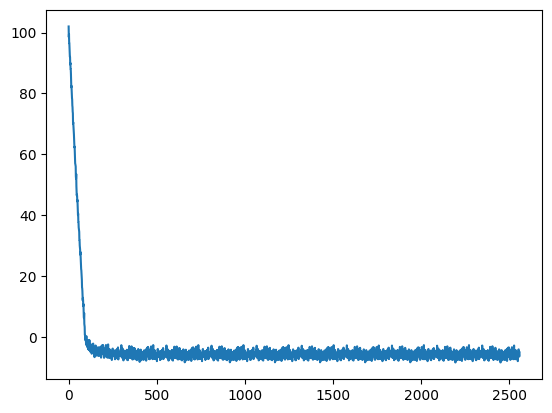

In [11]:
from matplotlib import pyplot as plt
import numpy as np

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_backup_heads",
#     mt.name.split("/")[-1],
#     f"{select_task.task_name}.npz"
# )

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    model_key.split("/")[-1],
    "distinct_options",
    # f"{select_task.task_name}",
    "select_one",
    # "legacy",
    "epoch_10.npz"
)

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "test_opt_code",
#     model_key.split("/")[-1],
#     "distinct_options",
#     f"{select_task.task_name}",
#     # "select_one",
#     "legacy",
#     "epoch_10.npz"
# )

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

79


(True, True)

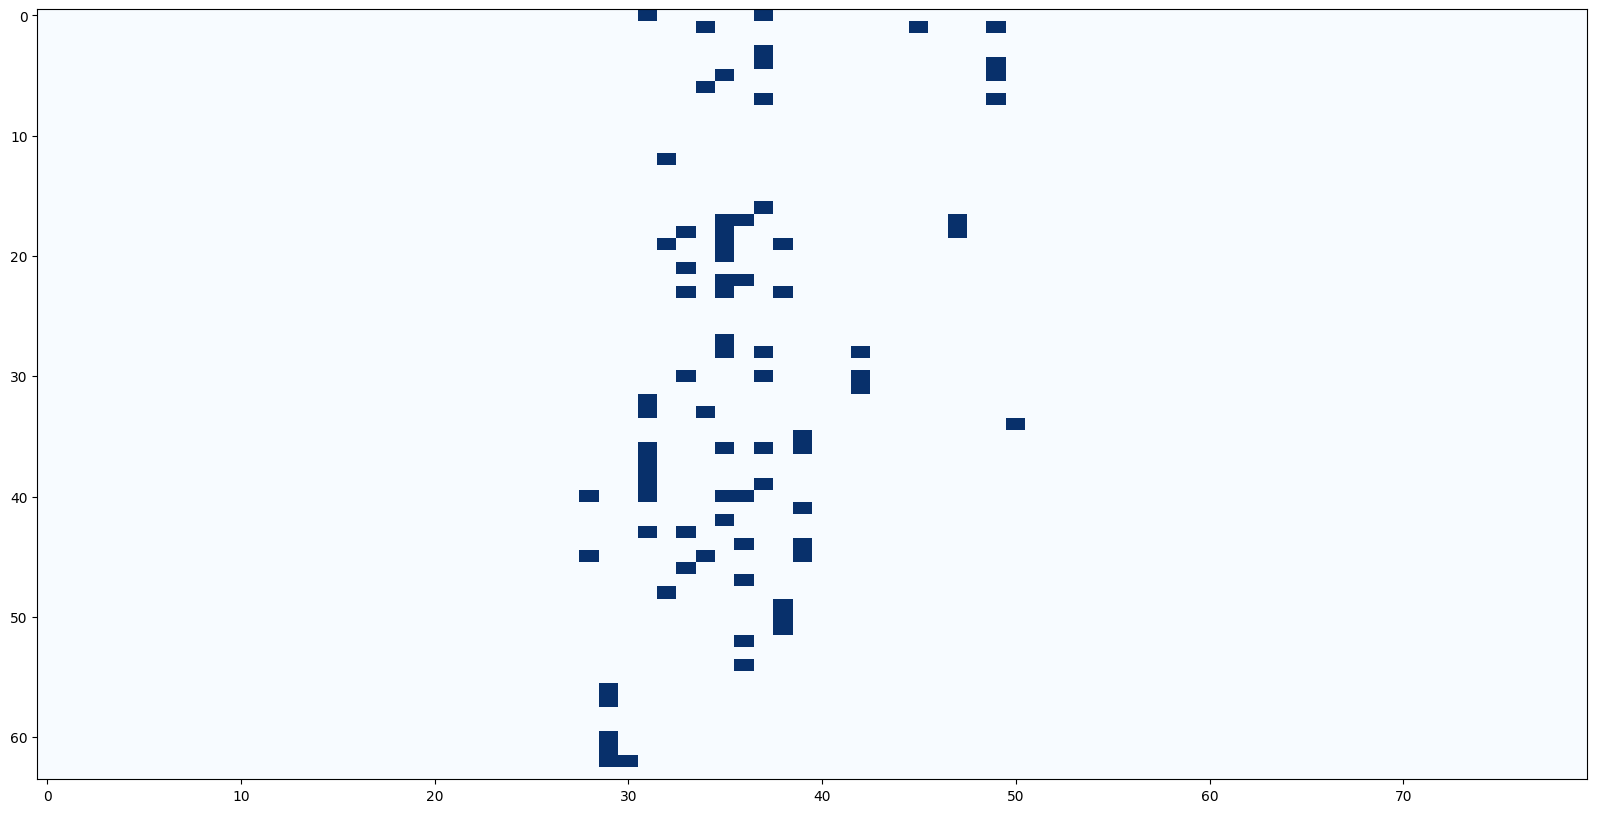

In [12]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[52:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

optimized_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
optimized_heads = [
    (layer_idx, head_idx) for layer_idx, head_idx in optimized_heads
]
print(len(optimized_heads))

HEADS = optimized_heads

(35, 19) in HEADS, (35, 19) in optimized_heads
# [(29, 3) in HEADS]

In [13]:
# from src.tokens import find_token_range, prepare_input

# string = sample.prompt()
# substring = sample.obj

# tokenized_prompt = prepare_input(
#     prompts=string, 
#     tokenizer=mt.tokenizer, 
#     return_offsets_mapping=True,
#     add_bos_token="qwen" in mt.name.lower()
# )
# string = mt.tokenizer.decode(tokenized_prompt.input_ids[0], skip_special_tokens=False)
# offset_mapping = tokenized_prompt.pop("offset_mapping")[0]

# ans_range = find_token_range(
#     string=string,
#     substring=substring,
#     offset_mapping=offset_mapping
# )
# print(f"Answer range: {ans_range}")
# print(f'"{mt.tokenizer.decode(tokenized_prompt.input_ids[0][range(*ans_range)])}"')
# # for idx, (tok, offset_range) in enumerate(zip(tokenized_prompt.input_ids[0], offset_mapping)):
# #     print(f"Token {idx}: \"{mt.tokenizer.decode([tok])}\" -- {offset_range}")

In [14]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(option_style="single_line"),
    options=sample.options,
    mt=mt,
    heads=optimized_heads,
    # heads = HEADS,
    # heads = [(35, 19)],
    start_from=1
)

2025-09-15 09:34:32 src.selection.functional DEBUG    Predictions: ['" Van"[13000] (p=0.436, logit=18.875)', '" Plum"[84409] (p=0.142, logit=17.750)', '" The"[578] (p=0.125, logit=17.625)', '" VAN"[97753] (p=0.097, logit=17.375)', '" Cherry"[45805] (p=0.076, logit=17.125)']
2025-09-15 09:34:32 src.selection.functional INFO     Combined attention matrix for all heads


In [15]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.functional import predict_next_token
from src.tokens import prepare_input

######################################################################
N_DISTRACTORS = 5
######################################################################

from src.selection.data import get_counterfactual_samples_within_task

In [16]:
from src.selection.data import get_counterfactual_samples_interface

counterfactual_sampler = get_counterfactual_samples_interface[select_task.task_name]

# patch_prompt_template_idx = 3
# clean_prompt_template_idx = 3


patch_sample, clean_sample = counterfactual_sampler(
    # patch_category="politician",
    # clean_category="actor",
    mt=mt,
    task=select_task,
    prompt_template_idx=prompt_template_idx,
    filter_by_lm_prediction=True,
    option_style=OPTION_STYLE,

    patch_category="fruit",
    clean_category="vehicle",
    # distinct_options=True,
    # patch_n_distractors=5,
    # clean_n_distractors=5,
    # patch_prompt_template_idx=patch_prompt_template_idx,
    # clean_prompt_template_idx=clean_prompt_template_idx,
    # patch_option_style="single_line",
    # clean_option_style="numbered",
    # n_options=5,
    # patch_yes_mode=False
)
print('=' * 20)
print(patch_sample.prompt(), ">>", f'"{mt.tokenizer.decode([patch_sample.ans_token_id])}"')
print(clean_sample.prompt(), ">>", f'"{mt.tokenizer.decode([clean_sample.ans_token_id])}"')

print(
    clean_sample.metadata["track_type_obj"], 
    clean_sample.metadata["track_type_obj_idx"], 
    mt.tokenizer.decode(clean_sample.metadata["track_type_obj_token_id"])
)

2025-09-15 09:34:35 src.selection.data DEBUG    Options: Kiwi, Helicopter, Yoga mat, Airplane, Banana.
What is the last fruit in this list above?
Answer: >>  Banana


2025-09-15 09:34:35 src.selection.data DEBUG    Options: Boat, Watermelon, Blueberry, Bus, Helmet.
What is the last vehicle in this list above?
Answer: >>  Bus
2025-09-15 09:34:35 src.selection.data DEBUG    Options: Boat, Watermelon, Blueberry, Bus, Helmet.
What is the last fruit in this list above?
Answer: >>  Blue
Options: Kiwi, Helicopter, Yoga mat, Airplane, Banana.
What is the last fruit in this list above?
Answer: >> " Banana"
Options: Boat, Watermelon, Blueberry, Bus, Helmet.
What is the last vehicle in this list above?
Answer: >> " Bus"
Blueberry 4  Blue


In [17]:
# order_sample_1 = SelectionSample(
#     subj="random",
#     category="test_order",
#     options=["Bike", "Apple", "Bed", "Dog", "Monitor", "Theater"],
#     obj="Apple",
#     obj_idx=1,
#     prompt_template="<_options_>\nWhat is the third item in the list?\nAnswer:",
#     answer="Apple",
# )

# order_sample_2 = SelectionSample(
#     subj="random",
#     category="test_order",
#     options=["Cat", "Chair", "Bus", "Phone", "Library", "Orange"],
#     obj="Phone",
#     obj_idx=3,
#     prompt_template="<_options_>\nWhat is the fifth item in the list?\nAnswer:",
#     answer="Phone",
# )
len(HEADS)

79

In [18]:
from src.functional import generate_with_patch
from src.selection.functional import verify_head_patterns

# patch_sample.options[patch_sample.obj_idx] = "Screw"
# patch_sample.options[patch_sample.obj_idx] = patch_sample.obj

gold_sample = copy.deepcopy(patch_sample)
gold_sample.options = clean_sample.options
gold_sample.ans_token_id = clean_sample.metadata["track_type_obj_token_id"]

for sample in [patch_sample, clean_sample, gold_sample]:
# for sample in [order_sample_1, order_sample_2]:
    print(sample.prompt(), ">>", f'"{mt.tokenizer.decode([sample.ans_token_id])}"')
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        mt=mt,
        # heads=qwen_72_heads,
        heads=optimized_heads,
        # heads=[(layer_idx, head_idx)],
        # generate_full_answer=True,
        query_index=-1
    )

Options: Kiwi, Helicopter, Yoga mat, Airplane, Banana.
What is the last fruit in this list above?
Answer: >> " Banana"
2025-09-15 09:34:37 src.selection.functional DEBUG    Predictions: ['" Banana"[76924] (p=0.762, logit=20.875)', '" The"[578] (p=0.103, logit=18.875)', '" Ki"[30558] (p=0.062, logit=18.375)', '" B"[426] (p=0.018, logit=17.125)', '" There"[2684] (p=0.007, logit=16.250)']
2025-09-15 09:34:37 src.selection.functional INFO     Combined attention matrix for all heads


Options: Boat, Watermelon, Blueberry, Bus, Helmet.
What is the last vehicle in this list above?
Answer: >> " Bus"
2025-09-15 09:34:38 src.selection.functional DEBUG    Predictions: ['" Bus"[19111] (p=0.691, logit=21.000)', '" The"[578] (p=0.154, logit=19.500)', '" Boat"[45332] (p=0.057, logit=18.500)', '" A"[362] (p=0.034, logit=18.000)', '" BUS"[23504] (p=0.016, logit=17.250)']
2025-09-15 09:34:38 src.selection.functional INFO     Combined attention matrix for all heads


Options: Boat, Watermelon, Blueberry, Bus, Helmet.
What is the last fruit in this list above?
Answer: >> " Blue"
2025-09-15 09:34:38 src.selection.functional DEBUG    Predictions: ['" Blue"[8868] (p=0.820, logit=20.875)', '" The"[578] (p=0.098, logit=18.750)', '" BLUE"[56992] (p=0.028, logit=17.500)', '" Water"[10164] (p=0.008, logit=16.250)', '" There"[2684] (p=0.005, logit=15.750)']
2025-09-15 09:34:38 src.selection.functional INFO     Combined attention matrix for all heads


In [19]:
clean_sample.metadata, patch_sample.metadata

({'track_category': 'fruit',
  'track_type_obj': 'Blueberry',
  'track_type_obj_idx': 4,
  'track_type_obj_token_id': 8868,
  'tokenized': {'input_ids': tensor([[128000,   3883,     25,  45332,     11,  10164,  72218,     11,   8868,
             15717,     11,  19111,     11,  67629,    627,   3923,    374,    279,
              1566,   7458,    304,    420,   1160,   3485,   5380,  16533,     25]],
          device='cuda:0'),
   'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            1, 1, 1]], device='cuda:0')},
  'predictions': [PredictedToken(token=' Bus', prob=0.69140625, logit=21.0, token_id=19111, metadata=None),
   PredictedToken(token=' The', prob=0.154296875, logit=19.5, token_id=578, metadata=None),
   PredictedToken(token=' Boat', prob=0.056884765625, logit=18.5, token_id=45332, metadata=None),
   PredictedToken(token=' A', prob=0.034423828125, logit=18.0, token_id=362, metadata=None),
   PredictedToken(token=' BUS', p

In [20]:
from src.selection.functional import cache_q_projections
from src.functional import interpret_logits
from src.tokens import prepare_input, find_token_range

prompts = [
    patch_sample.prompt(),
    clean_sample.prompt(),
]

tokenized = prepare_input(
    prompts=prompts,
    tokenizer=mt.tokenizer,
    return_offsets_mapping=True,
)

offset_mapping = tokenized.pop("offset_mapping")

question_ranges = [
    find_token_range(
        string=prompt,
        substring="?",
        occurrence=-1,
        offset_mapping=offset,
    )
    for prompt, offset in zip(prompts, offset_mapping)
]
ques_pos = [rng[1]-1 for rng in question_ranges]
for tok, q_pos in zip(tokenized.input_ids, ques_pos):
    assert mt.tokenizer.decode(tok[q_pos]).strip() == "?"

q_projections, out = cache_q_projections(
    mt=mt,
    input=tokenized,
    heads=HEADS,
    token_indices=[ [q_pos, -2, -1] for q_pos in ques_pos],
    return_output=True
)

In [21]:
tokenized

{'input_ids': tensor([[128000,   3883,     25,  30558,  17043,     11,  16183,  88323,     11,
          38673,   5634,     11,   6690,  19563,     11,  76924,    627,   3923,
            374,    279,   1566,  14098,    304,    420,   1160,   3485,   5380,
          16533,     25],
        [128009, 128009, 128000,   3883,     25,  45332,     11,  10164,  72218,
             11,   8868,  15717,     11,  19111,     11,  67629,    627,   3923,
            374,    279,   1566,   7458,    304,    420,   1160,   3485,   5380,
          16533,     25]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]])}

In [22]:
patch_logits = out.logits[0, -1, :]
interpret_logits(
    logits=patch_logits,
    tokenizer=mt.tokenizer,
)

[PredictedToken(token=' Banana', prob=0.75390625, logit=20.875, token_id=76924, metadata=None),
 PredictedToken(token=' The', prob=0.115234375, logit=19.0, token_id=578, metadata=None),
 PredictedToken(token=' Ki', prob=0.061767578125, logit=18.375, token_id=30558, metadata=None),
 PredictedToken(token=' B', prob=0.0177001953125, logit=17.125, token_id=426, metadata=None),
 PredictedToken(token=' There', prob=0.00738525390625, logit=16.25, token_id=2684, metadata=None)]

In [23]:
patch_logits = out.logits[1, -1, :]
interpret_logits(
    logits=patch_logits,
    tokenizer=mt.tokenizer,
)

[PredictedToken(token=' Bus', prob=0.67578125, logit=21.0, token_id=19111, metadata=None),
 PredictedToken(token=' The', prob=0.1708984375, logit=19.625, token_id=578, metadata=None),
 PredictedToken(token=' Boat', prob=0.0556640625, logit=18.5, token_id=45332, metadata=None),
 PredictedToken(token=' A', prob=0.03369140625, logit=18.0, token_id=362, metadata=None),
 PredictedToken(token=' BUS', prob=0.015869140625, logit=17.25, token_id=23504, metadata=None)]

In [24]:
q_projections[1].keys()

dict_keys([(28, 40, 26), (28, 40, -2), (28, 40, -1), (28, 45, 26), (28, 45, -2), (28, 45, -1), (29, 56, 26), (29, 56, -2), (29, 56, -1), (29, 57, 26), (29, 57, -2), (29, 57, -1), (29, 60, 26), (29, 60, -2), (29, 60, -1), (29, 61, 26), (29, 61, -2), (29, 61, -1), (29, 62, 26), (29, 62, -2), (29, 62, -1), (30, 62, 26), (30, 62, -2), (30, 62, -1), (31, 0, 26), (31, 0, -2), (31, 0, -1), (31, 32, 26), (31, 32, -2), (31, 32, -1), (31, 33, 26), (31, 33, -2), (31, 33, -1), (31, 36, 26), (31, 36, -2), (31, 36, -1), (31, 37, 26), (31, 37, -2), (31, 37, -1), (31, 38, 26), (31, 38, -2), (31, 38, -1), (31, 39, 26), (31, 39, -2), (31, 39, -1), (31, 40, 26), (31, 40, -2), (31, 40, -1), (31, 43, 26), (31, 43, -2), (31, 43, -1), (32, 12, 26), (32, 12, -2), (32, 12, -1), (32, 19, 26), (32, 19, -2), (32, 19, -1), (32, 48, 26), (32, 48, -2), (32, 48, -1), (33, 18, 26), (33, 18, -2), (33, 18, -1), (33, 21, 26), (33, 21, -2), (33, 21, -1), (33, 23, 26), (33, 23, -2), (33, 23, -1), (33, 30, 26), (33, 30, -2)

## Testing patching the query projection of a single head

In [25]:
# from src.selection.functional import cache_q_projections
from src.functional import patch_with_baukit, PatchSpec, repeat_kv, get_module_nnsight
from src.utils.typing import TokenizerOutput, Tokenizer
from src.selection.functional import cache_q_projections, verify_head_patterns

def find_quesmark_pos(
    prompt: str, 
    tokenizer: Tokenizer,
    tokenized: TokenizerOutput,
    offset_mapping: list[tuple[int, int]] | None = None,
    ques_mark: str = "?",
):
    if offset_mapping is None:
        if tokenized is None or "offset_mapping" not in tokenized:
            tokenized = prepare_input(
                prompts=[prompt], 
                tokenizer=tokenizer, 
                return_offsets_mapping=True,
            )
        offset_mapping = tokenized.pop("offset_mapping")[0]
    
    ques_range = find_token_range(
        string=prompt,
        substring=ques_mark,
        occurrence=-1,
        offset_mapping=offset_mapping
    )
    ques_pos = ques_range[1]-1
    assert tokenizer.decode(tokenized.input_ids[0][ques_pos]).strip() == ques_mark
    return ques_pos

mt.set_attn_implementation("eager")
mt.reset_forward()

# test_heads = [(35, 19)]
test_heads = copy.deepcopy(optimized_heads)

patch_tokenized = prepare_input(
    prompts=patch_sample.prompt(), 
    tokenizer=mt,
    return_offsets_mapping=True
)
patch_offsets = patch_tokenized.pop("offset_mapping")[0]
patch_ques_pos = find_quesmark_pos(
    prompt=patch_sample.prompt(),
    tokenizer=mt.tokenizer,
    tokenized=patch_tokenized,
    offset_mapping=patch_offsets
)

clean_tokenized = prepare_input(
    prompts=clean_sample.prompt(), 
    tokenizer=mt,
    return_offsets_mapping=True
)
clean_offsets = clean_tokenized.pop("offset_mapping")[0]
clean_ques_pos = find_quesmark_pos(
    prompt=clean_sample.prompt(),
    tokenizer=mt.tokenizer,
    tokenized=clean_tokenized,
    offset_mapping=clean_offsets
)

# indices = [patch_ques_pos, -2, -1]
indices = [-3, -2, -1]

q_states = cache_q_projections(
    mt=mt,
    input=patch_tokenized,
    heads=test_heads,
    token_indices=[indices],
)[0]

# map_indices = {patch_ques_pos: clean_ques_pos, -2: -2, -1: -1}
map_indices = {-3: -3, -2: -2, -1: -1}
q_patches = []
for (l_idx, h_idx, patch_token_idx), q_proj in q_states.items():
    q_patches.append(PatchSpec(
        location=(
            mt.attn_module_name_format.format(l_idx)+".q_proj",
            h_idx,
            map_indices[patch_token_idx]
        ),
        patch=q_proj.squeeze()
    ))

# The attention patterns for the patch sample should match exactly
test_inplace_swap = verify_head_patterns(
    prompt=patch_sample.prompt(),
    mt=mt,
    heads=test_heads,
    # heads=qwen_72_heads,
    tokenized_prompt=patch_tokenized,
    query_patches=q_patches
)

test_predicate_swap = verify_head_patterns(
    prompt=clean_sample.prompt(),
    mt=mt,
    heads=test_heads,
    # heads=qwen_72_heads,
    tokenized_prompt=clean_tokenized,
    query_patches=q_patches
)

2025-09-15 09:34:44 src.selection.functional DEBUG    Predictions: ['" Banana"[76924] (p=0.762, logit=20.875)', '" The"[578] (p=0.103, logit=18.875)', '" Ki"[30558] (p=0.062, logit=18.375)', '" B"[426] (p=0.018, logit=17.125)', '" There"[2684] (p=0.007, logit=16.250)']
2025-09-15 09:34:44 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-15 09:34:45 src.selection.functional DEBUG    Predictions: ['" Water"[10164] (p=0.699, logit=20.750)', '" Blue"[8868] (p=0.177, logit=19.375)', '" The"[578] (p=0.035, logit=17.750)', '" Boat"[45332] (p=0.024, logit=17.375)', '" A"[362] (p=0.008, logit=16.250)']
2025-09-15 09:34:45 src.selection.functional INFO     Combined attention matrix for all heads


In [26]:
(
    (patch_ques_pos, mt.tokenizer.decode(patch_tokenized.input_ids[0][patch_ques_pos])),
    (clean_ques_pos, mt.tokenizer.decode(clean_tokenized.input_ids[0][clean_ques_pos]))
)

((26, '?\n'), (24, '?\n'))

In [28]:
clean_tokenized.input_ids.shape, patch_tokenized.input_ids.shape

(torch.Size([1, 29]), torch.Size([1, 28]))

In [30]:
import baukit
from src.functional import get_module_nnsight, PatchSpec
from src.hooking.llama_attention import LlamaAttentionPatcher
import types
from typing import Literal
from src.tokens import prepare_input


def set_attn_implementation(mt, attn_implementation: Literal["sdpa", "eager"]):
    mt.config._attn_implementation = attn_implementation
    for layer_idx in range(mt.config.num_hidden_layers):
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)
        attn_block.config._attn_implementation = attn_implementation


###################################################################################
batch_size = 1  # tokenized.input_ids.shape[0]
n_heads = mt.config.num_attention_heads
head_dim = mt.n_embd // n_heads
query_idx = -1 # almost always the last token
###################################################################################

mt.reset_forward()
set_attn_implementation(mt, "sdpa")

layer_idx, head_idx = HEADS[0]

attn_block_name = mt.attn_module_name_format.format(layer_idx)
attn_block = baukit.get_module(mt._model, attn_block_name)
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(block_name=attn_block_name),
    attn_block,
)

patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)
patch_seq_len = patch_tokenized.input_ids.shape[1]
input_ln = mt.layer_name_format.format(layer_idx) + ".input_layernorm"

with mt.trace(patch_tokenized) as trace:
    ln_module = get_module_nnsight(mt, input_ln)
    patch_ln = ln_module.output.save()

    q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
    q_proj_module = get_module_nnsight(mt, q_proj_name)
    patch_q_proj = q_proj_module.output.view(batch_size, patch_seq_len, n_heads, head_dim).transpose(1, 2).save()
    # patch_q_proj = PatchSpec(
    #     location=(q_proj_name + f".{head_idx}", -1),
    #     patch=patch_q_proj[:, head_idx, query_idx, :].squeeze().save()
    # )

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
clean_seq_len = clean_tokenized.input_ids.shape[1]
with mt.trace(clean_tokenized) as trace:
    ln_module = get_module_nnsight(mt, input_ln)
    clean_ln = ln_module.output.save()

    q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
    q_proj_module = get_module_nnsight(mt, q_proj_name)
    clean_q_proj = q_proj_module.output.view(batch_size, clean_seq_len, n_heads, head_dim).transpose(1, 2).save()
    # clean_q_proj = PatchSpec(
    #     location=(q_proj_name + f".{head_idx}", -1),
    #     patch=clean_q_proj[:, head_idx, query_idx, :].squeeze().save()
    # )

mt.reset_forward()
set_attn_implementation(mt, "eager")

patch_q_proj.shape, clean_q_proj.shape, patch_ln.shape, clean_ln.shape

(torch.Size([1, 64, 27, 128]),
 torch.Size([1, 64, 27, 128]),
 torch.Size([1, 27, 8192]),
 torch.Size([1, 27, 8192]))

In [ ]:
from src.attention import visualize_attn_matrix
from src.functional import get_hs, interpret_logits

mt.reset_forward()
set_attn_implementation(mt, "sdpa")

layer_idx, head_idx = 35, 19
# layer_idx, head_idx = 62, 1

attn_matrices = {layer_idx: {}}

attn_block_name = mt.attn_module_name_format.format(layer_idx)
attn_block = baukit.get_module(mt._model, attn_block_name)
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(
        block_name=attn_block_name,
        save_attn_for=[head_idx],
        store_attn_matrices=attn_matrices[layer_idx],
    ),
    attn_block,
)

logit_location = (mt.lm_head_name, -1)
logits = get_hs(
    mt = mt,
    input = clean_tokenized,
    locations = [logit_location],
    return_dict=False
).squeeze()  # (seq_len, vocab_size)

mt.reset_forward()
set_attn_implementation(mt, "eager")

head_matrix = attn_matrices[layer_idx][head_idx].squeeze().to(torch.float32).cpu().numpy()

visualize_attn_matrix(
    attn_matrix=head_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=logits,
    interested_tokens=[clean_sample.metadata["track_type_obj_token_id"]],
)

In [ ]:
# type(mt._model), query_idx
head_idx, query_idx, patch_q_proj[:, head_idx, query_idx, :].shape

In [ ]:
from src.attention import visualize_attn_matrix

mt.reset_forward()
set_attn_implementation(mt, "sdpa")

attn_matrices = {layer_idx: {}}

attn_block_name = mt.attn_module_name_format.format(layer_idx)
attn_block = baukit.get_module(mt._model, attn_block_name)
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(
        block_name=attn_block_name,
        save_attn_for=[head_idx],
        store_attn_matrices=attn_matrices[layer_idx],
        query_patches=[(head_idx, query_idx, patch_q_proj[:, head_idx, query_idx, :].squeeze())],
    ),
    attn_block,
)

logit_location = (mt.lm_head_name, -1)
patch_logits = get_hs(
    mt = mt,
    # input = clean_tokenized,
    input=patch_tokenized,
    locations = [logit_location],
    return_dict=False
).squeeze()  # (seq_len, vocab_size)

mt.reset_forward()
set_attn_implementation(mt, "eager")

head_matrix = attn_matrices[layer_idx][head_idx].squeeze().to(torch.float32).cpu().numpy()

visualize_attn_matrix(
    attn_matrix=head_matrix,
    # tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    tokens=[mt.tokenizer.decode(t) for t in patch_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=patch_logits,
    interested_tokens=[clean_sample.metadata["track_type_obj_token_id"]],
)

In [ ]:
torch.allclose(patch_logits, logits, atol = 1e-3)

In [ ]:
torch.allclose(
    patch_q_proj[:, head_idx, query_idx, :], 
    clean_q_proj[:, head_idx, query_idx, :],
    atol=1e-3
)

In [ ]:
# torch.allclose(
#     patch_ln[:, query_idx, :], 
#     clean_ln[:, query_idx, :],
#     atol=1e-3
# )

In [ ]:
# patch_ln[:, query_idx, :], clean_ln[:, query_idx, :]

In [ ]:
# # manual calculation
# attn_module = baukit.get_module(mt._model, mt.attn_module_name_format.format(layer_idx))
# patch_q_proj_manual = attn_module.q_proj(patch_ln)
# clean_q_proj_manual = attn_module.q_proj(clean_ln)

# print(patch_q_proj_manual.shape, clean_q_proj_manual.shape)
# print(torch.allclose(
#     patch_q_proj_manual[:, query_idx, :], 
#     clean_q_proj_manual[:, query_idx, :],
#     atol=1e-3
# ))

# patch_q_proj_manual = patch_q_proj_manual.reshape(batch_size, patch_seq_len, n_heads, head_dim).transpose(1, 2)
# clean_q_proj_manual = clean_q_proj_manual.reshape(batch_size, clean_seq_len, n_heads, head_dim).transpose(1, 2)
# print(patch_q_proj_manual.shape, clean_q_proj_manual.shape)

# for idx in range(n_heads):
#     print(head_idx, torch.allclose(
#         patch_q_proj_manual[:, idx, query_idx, :], 
#         clean_q_proj_manual[:, idx, query_idx, :],
#         atol=1e-3
#     ))

In [ ]:
# torch.allclose(
#     patch_q_proj_manual[:, head_idx, query_idx, :], 
#     patch_q_proj[:, head_idx, query_idx, :],
#     atol=1e-3
# )

In [ ]:
replace_q_proj = clean_q_proj.clone()
replace_q_proj[:, head_idx, query_idx, :] = patch_q_proj[:, head_idx, query_idx, :]

print(torch.allclose(
        replace_q_proj[:, head_idx, query_idx, :],
        clean_q_proj[:, head_idx, query_idx, :],
        atol=1e-3
    )
)
print(replace_q_proj.shape)

replace_q_proj = replace_q_proj.transpose(1, 2).reshape(batch_size, clean_seq_len, -1)

rep_patch = PatchSpec(
    location=(q_proj_name, -1),
    patch=replace_q_proj[:, -1, :].squeeze(),
)

ln_patch = PatchSpec(
    location=(input_ln, -1),
    patch=patch_ln[:, query_idx, :].squeeze(),
)

head_q_patch = PatchSpec(
    location=(q_proj_name, head_idx, -1),
    patch=patch_q_proj[:, head_idx, query_idx, :].squeeze(),
)

head_q_patch.location, rep_patch.location

In [ ]:
# clean_q_proj_rs = clean_q_proj.view(batch_size, clean_seq_len, -1)
# patch_q_proj_rs = patch_q_proj.view(batch_size, clean_seq_len, -1)
# clean_q_proj_rs[:, -1, :].shape, patch_q_proj_rs[:, -1, :].shape

In [ ]:
# torch.allclose(
#     replace_q_proj[:, -1, :].squeeze(), 
#     # patch_q_proj_rs[:, -1, :].squeeze(),
#     clean_q_proj_rs[:, -1, :].squeeze(), 
#     atol=1e-3
# )

In [ ]:
patch_q_proj.shape, clean_q_proj.shape
# torch.allclose(patch_q_proj.patch, clean_q_proj.patch)

In [ ]:
clean_sample.metadata

In [ ]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import interpret_logits

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)

attn_info = get_attention_matrices(
    input=clean_tokenized,
    mt=mt,
)

attn_matrix = attn_info.attention_matrices[layer_idx, head_idx].squeeze()
visualize_attn_matrix(
    attn_matrix=attn_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=attn_info.logits,
    interested_tokens=[clean_sample.ans_token_id, clean_sample.metadata["track_type_obj_token_id"]]
)

In [ ]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import patch_with_nnsight, patch_with_baukit

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)

patched_attn_info = get_attention_matrices(
    input=clean_tokenized,
    mt=mt,
    # patches=[ln_patch],
    patches = [head_q_patch],
    # patches = [rep_patch],
    # patch_interface=patch_with_nnsight
    patch_interface=patch_with_baukit
)

patched_attn_matrix = patched_attn_info.attention_matrices[layer_idx, head_idx].squeeze()
visualize_attn_matrix(
    attn_matrix=patched_attn_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=patched_attn_info.logits,
    interested_tokens=[clean_sample.ans_token_id, clean_sample.metadata["track_type_obj_token_id"]]
)

## Patching a bunch of heads

### Loading the Heads

#### Attention Behavior

In [50]:
from tqdm.auto import tqdm
from scripts.locate_via_attention_behavior import SelectionSampleAttn

attn_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/attention_patterns/select_one",
    # mt.name.split("/")[-1],
    model_key.split("/")[-1],
    "objects"
)
files = sorted(os.listdir(attn_path))
print(files)

#######################################################################
# LIMIT = 128
LIMIT = len(files)
#######################################################################

selection_attns = []

for npz_file in tqdm(files[:LIMIT]):
    if not npz_file.endswith(".npz"):
        continue

    npz_path = os.path.join(attn_path, npz_file)
    selection_attns.append(SelectionSampleAttn.from_npz(npz_path))
    if len(selection_attns) % 128 == 0:
        print(f"Loaded {len(selection_attns)}/{LIMIT} files")

len(selection_attns)

['sample_0000.npz', 'sample_0001.npz', 'sample_0002.npz', 'sample_0003.npz', 'sample_0004.npz', 'sample_0005.npz', 'sample_0006.npz', 'sample_0007.npz', 'sample_0008.npz', 'sample_0009.npz', 'sample_0010.npz', 'sample_0011.npz', 'sample_0012.npz', 'sample_0013.npz', 'sample_0014.npz', 'sample_0015.npz', 'sample_0016.npz', 'sample_0017.npz', 'sample_0018.npz', 'sample_0019.npz', 'sample_0020.npz', 'sample_0021.npz', 'sample_0022.npz', 'sample_0023.npz', 'sample_0024.npz', 'sample_0025.npz', 'sample_0026.npz', 'sample_0027.npz', 'sample_0028.npz', 'sample_0029.npz', 'sample_0030.npz', 'sample_0031.npz', 'sample_0032.npz', 'sample_0033.npz', 'sample_0034.npz', 'sample_0035.npz', 'sample_0036.npz', 'sample_0037.npz', 'sample_0038.npz', 'sample_0039.npz', 'sample_0040.npz', 'sample_0041.npz', 'sample_0042.npz', 'sample_0043.npz', 'sample_0044.npz', 'sample_0045.npz', 'sample_0046.npz', 'sample_0047.npz', 'sample_0048.npz', 'sample_0049.npz', 'sample_0050.npz', 'sample_0051.npz', 'sample_005

  0%|          | 0/2048 [00:00<?, ?it/s]

Loaded 128/2048 files
Loaded 256/2048 files
Loaded 384/2048 files
Loaded 512/2048 files
Loaded 640/2048 files
Loaded 768/2048 files
Loaded 896/2048 files
Loaded 1024/2048 files
Loaded 1152/2048 files
Loaded 1280/2048 files
Loaded 1408/2048 files
Loaded 1536/2048 files
Loaded 1664/2048 files
Loaded 1792/2048 files
Loaded 1920/2048 files
Loaded 2048/2048 files


2048

In [51]:
from src.attention import visualize_attn_matrix

sample_idx = 3

layer_idx, head_idx = 35, 19 # llama-70B
# layer_idx, head_idx = 54, 44 # qwen-72B
# layer_idx, head_idx = 51, 11 # qwen-32B
# layer_idx, head_idx = 29, 3 # gemma-27b


selection_attn = selection_attns[sample_idx]
print(selection_attn.resolution_score(layer_idx, head_idx))
visualize_attn_matrix(
    attn_matrix=selection_attn.attention_pattern.attention_matrices[layer_idx, head_idx],
    tokens=selection_attn.attention_pattern.tokenized_prompt,
    q_index=-1,
    start_from=1,
)

(0.784423828125, 0.8125, [0.013607025146484375, 0.000949859619140625, 0.028076171875, 0.006317138671875, 0.01116943359375])


In [52]:
selection_attns[0].attention_pattern.attention_matrices.shape

(80, 64, 30, 30)

In [53]:
selection_attn.score_per_option(
    layer_idx=35, head_idx=19, query_idx=-1, 
    value_weighted=True,
    include_delim=True
)

[0.056003570556640625,
 2.0927734375,
 0.0099639892578125,
 0.076690673828125,
 0.03558349609375,
 0.03022003173828125]

In [54]:
selection_attn.resolution_score(
    layer_idx=35, head_idx=19, query_idx=-1,
    value_weighted=True,
    include_delim=True
)

(2.016082763671875,
 2.0927734375,
 [0.056003570556640625,
  0.0099639892578125,
  0.076690673828125,
  0.03558349609375,
  0.03022003173828125])

In [55]:
selection_attn.sample.prompt()

'Options: Submarine, Microwave, Hospital, Coffee table, Binder, Comb.\nWhich among these objects mentioned above is a kitchen appliance?\nAnswer:'

In [60]:
from tqdm.auto import tqdm

#############################################################################
n_layer = selection_attns[0].attention_pattern.attention_matrices.shape[0]
n_head = selection_attns[0].attention_pattern.attention_matrices.shape[1]
token_idx = "all"
# token_idx = "last"
##############################################################################

resolution_scores = torch.zeros((n_head, n_layer), dtype=torch.float32)
for selection_attn in tqdm(selection_attns):
    for layer_idx in range(n_layer):
        for head_idx in range(n_head):
            resolution_scores[head_idx, layer_idx] += selection_attn.resolution_score(
                layer_idx, head_idx, token_idx=token_idx,
                # value_weighted=True,
                include_delim=True
            )[0]
            # resolution_scores[head_idx, layer_idx] += selection_attn.first_token_score(
            #     layer_idx, head_idx
            # )[0]

resolution_scores /= len(selection_attns)
resolution_scores.shape

  0%|          | 0/2048 [00:00<?, ?it/s]

torch.Size([64, 80])

2025-09-13 20:42:27 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fb5e1907f50>


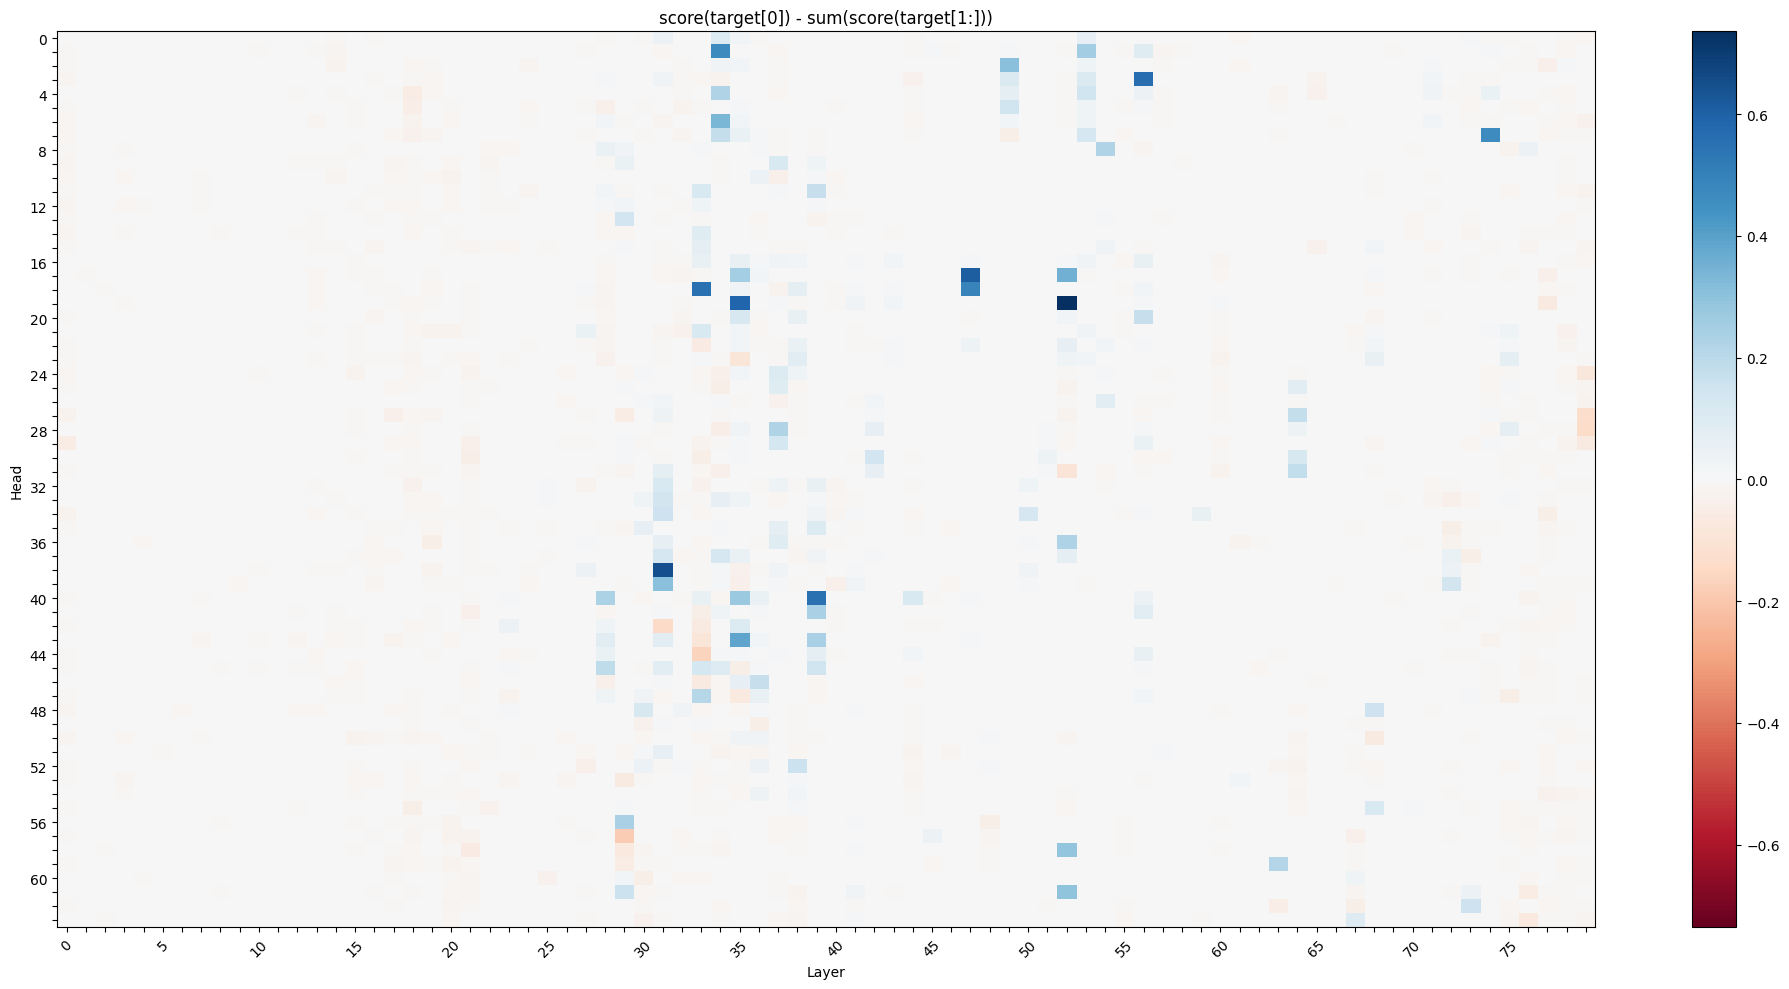

Layer 52, Head 19: 0.7359
Layer 31, Head 38: 0.6496
Layer 47, Head 17: 0.6041
Layer 35, Head 19: 0.5826
Layer 56, Head 3: 0.5629
Layer 33, Head 18: 0.5513
Layer 39, Head 40: 0.5512
Layer 47, Head 18: 0.4940
Layer 34, Head 1: 0.4678
Layer 74, Head 7: 0.4647
Layer 35, Head 43: 0.3893
Layer 52, Head 17: 0.3553
Layer 34, Head 6: 0.3361
Layer 49, Head 2: 0.3102
Layer 31, Head 39: 0.3061


In [61]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 10))
scale = torch.max(torch.abs(resolution_scores))
plt.imshow(
    resolution_scores.cpu().numpy(),
    cmap="RdBu",
    aspect="auto",
    vmin=-scale,
    vmax=scale,
)
plt.colorbar()
# plt.title(f"score(target) - max(score(distractors)) | {token_idx.upper()} tokens of options")
plt.title("score(target[0]) - sum(score(target[1:]))")
plt.xlabel("Layer")
plt.ylabel("Head")

def get_ticks(ticks, skip=5):
    ret = []
    for i in ticks:
        if i % skip == 0:
            ret.append(str(i))
        else:
            ret.append("")
    return ret

plt.xticks(
    ticks=range(n_layer),
    labels=get_ticks(range(n_layer)),
    rotation=45,
)
plt.yticks(
    ticks=range(n_head),
    labels=get_ticks(range(n_head), skip=4),
)

plt.tight_layout()
plt.show()


scores_per_head = []
for head_idx in range(n_head):
    for layer_idx in range(n_layer):
        scores_per_head.append(
            (head_idx, layer_idx, resolution_scores[head_idx, layer_idx].item())
        )

scores_per_head = sorted(scores_per_head, key=lambda x: x[2], reverse=True)
for head_idx, layer_idx, score in scores_per_head[:15]:
    print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")

In [62]:
heads_attn_behavior = [(layer_idx, head_idx) for layer_idx, head_idx, score in scores_per_head[:100]]
print(heads_attn_behavior)

[(19, 52), (38, 31), (17, 47), (19, 35), (3, 56), (18, 33), (40, 39), (18, 47), (1, 34), (7, 74), (43, 35), (17, 52), (6, 34), (2, 49), (39, 31), (61, 52), (58, 52), (40, 35), (1, 53), (17, 35), (56, 29), (41, 39), (43, 39), (40, 28), (36, 52), (8, 54), (28, 37), (4, 34), (59, 63), (47, 33), (45, 28), (31, 64), (27, 64), (7, 34), (46, 36), (20, 56), (11, 39), (61, 29), (52, 38), (62, 73), (48, 68), (34, 31), (45, 39), (5, 49), (4, 53), (30, 42), (13, 29), (39, 72), (33, 31), (45, 33), (29, 37), (37, 34), (37, 31), (34, 50), (7, 53), (48, 30), (20, 35), (30, 64), (40, 44), (11, 33), (9, 37), (55, 68), (32, 31), (21, 33), (3, 53), (3, 49), (42, 35), (0, 34), (35, 39), (24, 37), (63, 67), (45, 34), (1, 56), (25, 37), (14, 33), (36, 37), (26, 54), (25, 64), (41, 56), (23, 38), (43, 28), (45, 31), (43, 31), (37, 52), (15, 33), (23, 75), (44, 39), (4, 49), (18, 38), (35, 37), (31, 31), (28, 75), (51, 31), (46, 35), (31, 42), (35, 30), (22, 52), (36, 31), (33, 34), (0, 53)]


#### Based on Patching Score

In [71]:
from scripts.patching_within_task import SelectionQprojPatchResult
from tqdm.auto import tqdm


q_proj_root = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/q_states_patching_old",
    # mt.name.split("/")[-1],
    model_key.split("/")[-1],
)

#############################################
# LIMIT = 20
LIMIT = None
# n_layer = mt.n_layer
# n_head = mt.config.num_attention_heads
categories = [
    # "profession",
    # "nationality",
    "objects",
]
#############################################

q_proj_results = {cat: [] for cat in categories}

for category in categories:
    print(f"category: {category}")
    q_proj_path = os.path.join(q_proj_root, category)
    files = sorted(os.listdir(q_proj_path))
    LIMIT = LIMIT or len(files)
    q_proj_results[category] = []
    for file in tqdm(files[:LIMIT]):
        if not file.endswith(".json"):
            continue

        file_path = os.path.join(q_proj_path, file)
        q_proj_results[category].append(SelectionQprojPatchResult.load_from_json(file_path))
        # if len(q_proj_results) % 10 == 0:
        #     print(f"Loaded {len(q_proj_results)}/{LIMIT} files")



category: objects


  0%|          | 0/150 [00:00<?, ?it/s]

In [72]:
# import copy
# combine_all_results = []
# for category in categories:
#     combine_all_results.extend(q_proj_results[category])
# results_copy = copy.deepcopy(q_proj_results)
# results_copy["all"] = combine_all_results

results_copy = q_proj_results

In [73]:
# len(results_copy["objects"])

In [74]:
heads = results_copy["objects"][0].headwise_patching_effects.keys()
layers = set([layer for layer, head in heads])
heads = set([head for layer, head in heads])    

2025-09-13 22:46:23 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f9eb99f0710>


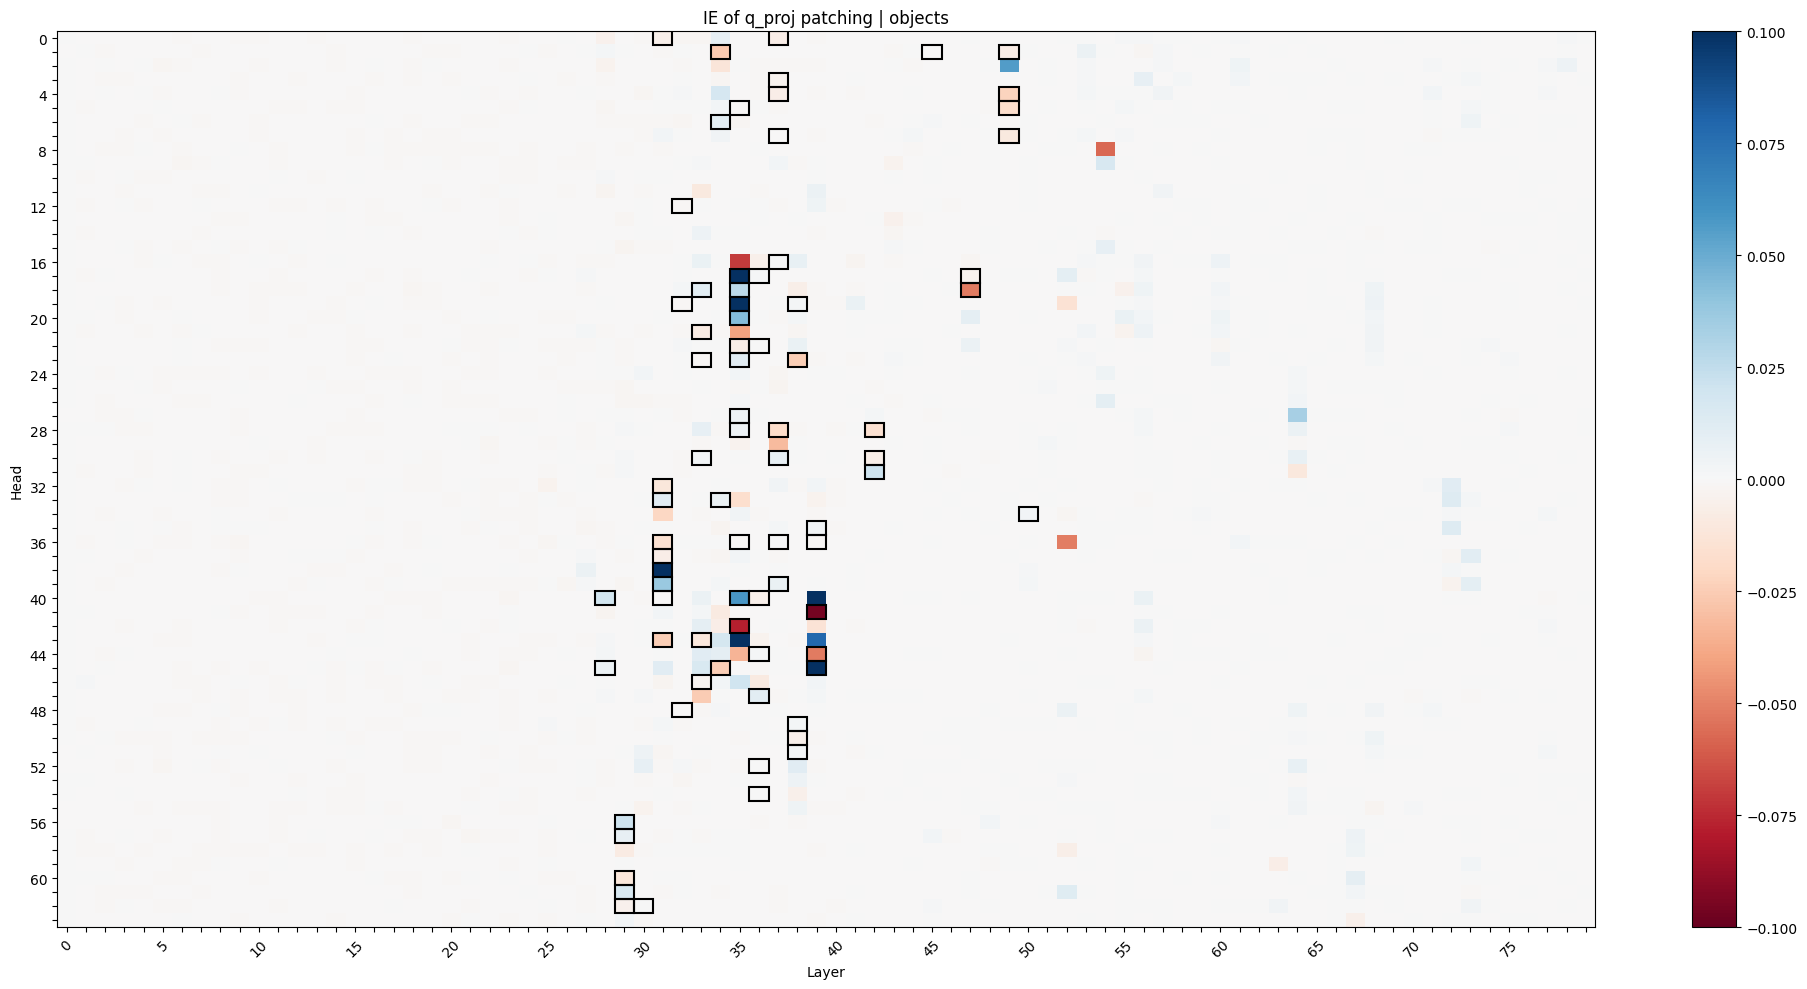

Layer 35, Head 19: 0.3127
Layer 31, Head 38: 0.1344
Layer 39, Head 45: 0.1280
Layer 39, Head 40: 0.1267
Layer 35, Head 17: 0.1187
Layer 35, Head 43: 0.1093
Layer 39, Head 43: 0.0782
Layer 35, Head 40: 0.0585
Layer 49, Head 2: 0.0557
Layer 35, Head 20: 0.0431
Layer 31, Head 39: 0.0375
Layer 64, Head 27: 0.0333
Layer 35, Head 18: 0.0262
Layer 29, Head 56: 0.0206
Layer 42, Head 31: 0.0205


In [94]:
import json
import matplotlib.patches as patches

n_layer = len(layers)
n_heads = len(heads)

category_wise_heads = {}
for category, categorywise_result in results_copy.items():
    indirect_effects = torch.zeros((n_layer, n_heads), dtype=torch.float32)
    for layer_idx in range(n_layer):
        for head_idx in range(n_heads):
            indirect_effects[layer_idx, head_idx] = torch.mean(
                torch.tensor(
                    [
                        sample_result.head_effect(layer_idx, head_idx)
                        for sample_result in categorywise_result
                    ]
                )
            )

    plt.figure(figsize=(20, 10))
    scale = torch.max(torch.abs(indirect_effects))
    plt.imshow(
        indirect_effects.T.cpu().numpy(),
        cmap="RdBu",
        aspect="auto",
        # vmin=-scale,
        # vmax=scale,
        vmin=-0.1,
        vmax=0.1
    )
    plt.colorbar()
    # plt.title(f"score(target) - max(score(distractors)) | {token_idx.upper()} tokens of options")
    plt.title("IE of q_proj patching | " + category)
    plt.xlabel("Layer")
    plt.ylabel("Head")

    def get_ticks(ticks, skip=5):
        ret = []
        for i in ticks:
            if i % skip == 0:
                ret.append(str(i))
            else:
                ret.append("")
        return ret

    plt.xticks(
        ticks=range(n_layer),
        labels=get_ticks(range(n_layer)),
        rotation=45,
    )
    plt.yticks(
        ticks=range(n_head),
        labels=get_ticks(range(n_head), skip=4),
    )

    # # Get the current axes
    ax = plt.gca()

    # Draw borders around marked cells
    for (x, y) in optimized_heads:
        # Create a Rectangle patch
        # Note: (x-0.5, y-0.5) positions the rectangle correctly around the cell
        # Width and height of 1 covers exactly one cell
        rect = patches.Rectangle(
            (x - 0.5, y - 0.5),  # bottom-left corner
            1,                     # width
            1,                     # height
            linewidth=1.5,          # border thickness
            edgecolor='black',    # border color (you can change this)
            facecolor='none'      # no fill, just border
        )
        ax.add_patch(rect)

    plt.tight_layout()
    plt.show()


    scores_per_head = []
    for layer_idx in layers:
        for head_idx in heads:
            scores_per_head.append(
                (layer_idx, head_idx, indirect_effects[layer_idx, head_idx].item())
            )

    scores_per_head = sorted(scores_per_head, key=lambda x: x[2], reverse=True)
    category_wise_heads[category] = scores_per_head
    for layer_idx, head_idx, score in scores_per_head[:15]:
        print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")

with open("category_wise_heads.json", "w") as f:
    json.dump(category_wise_heads, f, indent=4)

In [95]:
for layer_idx, head_idx, score in scores_per_head[:15]:
    print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")

Layer 35, Head 19: 0.3127
Layer 31, Head 38: 0.1344
Layer 39, Head 45: 0.1280
Layer 39, Head 40: 0.1267
Layer 35, Head 17: 0.1187
Layer 35, Head 43: 0.1093
Layer 39, Head 43: 0.0782
Layer 35, Head 40: 0.0585
Layer 49, Head 2: 0.0557
Layer 35, Head 20: 0.0431
Layer 31, Head 39: 0.0375
Layer 64, Head 27: 0.0333
Layer 35, Head 18: 0.0262
Layer 29, Head 56: 0.0206
Layer 42, Head 31: 0.0205


#### Performing the Patch

In [ ]:
from src.tokens import prepare_input
from src.functional import get_module_nnsight

# HEADS = [
#     (33, 45),
#     (33, 18),
#     (34, 1),
#     (34, 6),
#     (34, 7),
#     (35, 19),
#     (39, 40),
#     (42, 30),
#     (47, 18),
#     (52, 58),
# ]

# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:50]
# ]

# HEADS = heads_selected

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)

# category_wise_heads["all"][len(HEADS) - 1]

In [ ]:
from src.utils.typing import TokenizerOutput


@torch.inference_mode()
def cache_q_projections(
    mt: ModelandTokenizer,
    input: TokenizerOutput,
    query_locations: list[tuple[int, int, int]],  # (layer_idx, head_idx, query_idx)
    return_output: bool = False,
):
    layer_to_hq = {}
    for layer_idx, head_idx, query_idx in query_locations:
        if layer_idx not in layer_to_hq:
            layer_to_hq[layer_idx] = []
        layer_to_hq[layer_idx].append((head_idx, query_idx))

    q_projections = {}
    batch_size = input.input_ids.shape[0]
    seq_len = input.input_ids.shape[1]
    n_heads = mt.config.num_attention_heads
    head_dim = mt.n_embd // n_heads
    with mt.trace(input) as tracer:
        for layer_idx, query_locs in layer_to_hq.items():
            q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
            q_proj_module = get_module_nnsight(mt, q_proj_name)
            q_proj_out = q_proj_module.output.view(
                batch_size, seq_len, n_heads, head_dim
            ).transpose(1, 2)
            for head_idx, query_idx in query_locs:
                q_projections[(layer_idx, head_idx, query_idx)] = (
                    q_proj_out[:, head_idx, query_idx, :].squeeze().save()
                )

        if return_output:
            output = mt.output.save()

    if return_output:
        return q_projections, output
    return q_projections

In [ ]:
query_indices = list(range(-3, 0))
query_locations = [
    (layer_idx, head_idx, query_idx)
    for layer_idx, head_idx in HEADS
    for query_idx in query_indices
]

cached_q_states = cache_q_projections(
    mt=mt,
    input=patch_tokenized,
    query_locations=query_locations,
)

# cached_q_states[(HEADS[0])].shape

In [ ]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import interpret_logits

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)

# attn_info = get_attention_matrices(
#     input=clean_tokenized,
#     mt=mt,
# )

# layer_idx, head_idx = 35, 19
# attn_matrix = attn_info.attention_matrices[layer_idx, head_idx].squeeze()
# visualize_attn_matrix(
#     attn_matrix=attn_matrix,
#     tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
#     q_index=-1,
# )

# interpret_logits(
#     tokenizer=mt,
#     logits=attn_info.logits,
#     interested_tokens=[clean_sample.obj_token_id, clean_sample.metadata["track_type_obj_token_id"]]
# )

attn_pattern = verify_head_patterns(
    prompt = clean_tokenized,
    options = clean_sample.options,
    pivot = clean_sample.subj,
    mt = mt,
    heads = HEADS,
    # heads = patching_heads,
    generate_full_answer=True,
)

attn_pattern["predictions"]

In [ ]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import patch_with_nnsight, patch_with_baukit, PatchSpec

q_proj_patches = []
for (layer_idx, head_idx, query_idx), q_proj in cached_q_states.items():
    q_proj_patches.append(
        PatchSpec(
            location=(mt.attn_module_name_format.format(layer_idx) + ".q_proj", head_idx, query_idx),
            patch=q_proj
        )
    )

# patched_attn_info = get_attention_matrices(
#     input=clean_tokenized,
#     mt=mt,
#     patches=q_proj_patches,
#     patch_interface=patch_with_baukit
# )

# layer_idx, head_idx = 35, 19
# patched_attn_matrix = patched_attn_info.attention_matrices[layer_idx, head_idx].squeeze()
# visualize_attn_matrix(
#     attn_matrix=patched_attn_matrix,
#     tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
#     q_index=-1,
# )

# interpret_logits(
#     tokenizer=mt,
#     logits=patched_attn_info.logits,
#     interested_tokens=[clean_sample.obj_token_id, clean_sample.metadata["track_type_obj_token_id"]]
# )

patched_attn_pattern = verify_head_patterns(
    prompt = clean_tokenized,
    options = clean_sample.options,
    pivot = clean_sample.subj,
    mt = mt,
    heads = HEADS,
    # heads = patching_heads,
    query_patches=q_proj_patches,
    # generate_full_answer=True,
)

patched_attn_pattern["predictions"]

### Search over layers and heads

In [ ]:
clean_sample.metadata

In [ ]:
from scripts.patching_within_task import SelectionQprojPatchResult

In [ ]:
from itertools import product
from src.functional import patch_with_baukit, interpret_logits
from src.selection.functional import cache_q_projections

all_heads = list(product(range(20, 30), range(mt.config.num_attention_heads)))
query_indices = {-3: -3, -2: -2, -1: -1}

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)

interested_tokens = [
    patch_sample.ans_token_id,
    clean_sample.ans_token_id,
    clean_sample.metadata["track_type_obj_token_id"]
]


query_locations = [
    (layer_idx, head_idx, patch_query_idx)
    for layer_idx, head_idx in all_heads
    for patch_query_idx in query_indices.keys()
]

all_q_projections, patch_out = cache_q_projections(
    mt=mt,
    input=patch_tokenized,
    query_locations=query_locations,
    return_output=True,
)
logger.debug(len(all_q_projections))

patch_logits = patch_out.logits[:, -1, :].squeeze()
patch_precitions, patch_track = interpret_logits(
    tokenizer=mt,
    logits=patch_logits,
    interested_tokens=interested_tokens,
)

patch_precitions, patch_track

In [ ]:
clean_out = patch_with_baukit(
    mt=mt,
    inputs=clean_tokenized,
    patches=[],
)

base_logits = clean_out.logits[:, -1, :].squeeze()
base_predictions, base_track = interpret_logits(
    tokenizer=mt,
    logits=base_logits,
    interested_tokens=interested_tokens,
)
base_predictions, base_track

In [ ]:
from src.functional import PatchSpec
q_proj_patches = []
for (layer_idx, head_idx, patch_query_idx), q_proj in all_q_projections.items():
    q_proj_patches.append(
        PatchSpec(
            location=(
                mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                head_idx,
                query_indices[patch_query_idx],
            ),
            patch=q_proj,
        )
    )

int_out = patch_with_baukit(
    mt = mt,
    inputs = clean_tokenized,
    patches = q_proj_patches,
)

logits = int_out.logits[:, -1, :].squeeze()

interpret_logits(
    tokenizer=mt,
    logits=logits,
    interested_tokens=interested_tokens
)

In [ ]:
len(all_q_projections)

In [ ]:
list(all_q_projections.keys())[:5]

In [ ]:
from tqdm.auto import tqdm
head_wise_patching_effects = {}

for (layer_idx, head_idx) in tqdm(all_heads):
    q_proj_patch = []
    for patch_tok_idx, clean_tok_idx in query_indices.items():
        q_proj_patch.append(
            PatchSpec(
                location=(
                    mt.attn_module_name_format.format(layer_idx) + ".q_proj", 
                    head_idx, 
                    query_indices[patch_tok_idx]
                ),
                patch=all_q_projections[(layer_idx, head_idx, patch_tok_idx)]
            )
        )
    out = patch_with_baukit(
        mt = mt,
        inputs = clean_tokenized,
        patches = q_proj_patch,
    )
    logits = out.logits[:, -1, :].squeeze()
    predictions, track = interpret_logits(
        tokenizer=mt,
        logits=logits,
        interested_tokens=interested_tokens
    )
    head_wise_patching_effects[(layer_idx, head_idx)] = track

In [ ]:
patching_results = SelectionQprojPatchResult(
    patch_sample=patch_sample,
    clean_sample=clean_sample,
    interested_tokens=interested_tokens,
    base_results=base_track,
    gold_results=patch_track,
    headwise_patching_effects=head_wise_patching_effects
)

In [ ]:
patching_results.head_effect(layer_idx=25, head_idx=19)

In [ ]:
headwise_scores = [
    (
        layer_idx,
        head_idx,
        patching_results.head_effect(layer_idx, head_idx)
    )
    for layer_idx, head_idx in head_wise_patching_effects.keys()
]

headwise_scores = sorted(headwise_scores, key=lambda x: x[2], reverse=True)
patching_heads = []
for layer_idx, head_idx, score in headwise_scores[:15]:
    print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")
    patching_heads.append((layer_idx, head_idx))

In [ ]:
patching_results.patch_sample.metadata.pop("tokenized")
patching_results.clean_sample.metadata.pop("tokenized")

In [ ]:
patching_results.delist_patching_effects()


In [ ]:
with open("patching_results.json", "w") as f:
    json.dump(patching_results.to_dict(), f, indent=4)

In [ ]:
with open("patching_results.json", "r") as f:
    loaded_results = json.load(f)

loaded_results["headwise_patching_effects"] = {
    (int(layer_idx.split("_<>_")[0]), int(layer_idx.split("_<>_")[1])): effect
    for layer_idx, effect in loaded_results["headwise_patching_effects"].items()
}

In [ ]:
loaded_results["headwise_patching_effects"].keys()

In [ ]:
patching_results_loaded = SelectionQprojPatchResult.from_dict(loaded_results)
patching_results_loaded.head_effect(layer_idx=25, head_idx=19)

In [ ]:
mt.config.num_attention_heads

## Optimization to select heads to patch

In [34]:
#################################################################################
train_limit = 512
# prompt_template_idx = 1
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

In [35]:
from src.functional import free_gpu_cache
from src.selection.data import get_counterfactual_samples_interface
from src.selection.data import CounterFactualSamplePair


train_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "train",
    mt.name.split("/")[-1],
    select_task.task_name,
    "objects",
)
os.makedirs(train_samples_save_path, exist_ok=True)

train_set = []
while len(train_set) < train_limit:
    print(f"sample {len(train_set)+1} / {train_limit}")
    patch, clean = counterfactual_sampler(
        mt=mt,
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        # distinct_options=True,
        # # n_distractors=N_DISTRACTORS,
        # patch_n_distractors=N_DISTRACTORS,
        # clean_n_distractors=N_DISTRACTORS
        n_options = random.choice([4, 5, 6, 7])
    )
    train_set.append((clean, patch))

    cf_pair = CounterFactualSamplePair(
        patch_sample=patch,
        clean_sample=clean,
    )
    cf_pair.detensorize()
    with open(os.path.join(train_samples_save_path, f"{len(train_set):05d}.json"), "w") as f:
        json.dump(cf_pair.to_dict(), f, indent=2)

len(train_set)

sample 1 / 512
2025-09-15 00:09:52 src.selection.data DEBUG    Options: Dress, Temple, Highlighter, Daffodil, Factory, Iris, Surfboard.
What is the last flower in this list above?
Answer: >>  Iris


2025-09-15 00:09:52 src.selection.data DEBUG    Options: Shorts, Jasmine, Mosque, Orchid, Football, Paper, Church.
What is the last building in this list above?
Answer: >>  Church
2025-09-15 00:09:52 src.selection.data DEBUG    Options: Shorts, Jasmine, Mosque, Orchid, Football, Paper, Church.
What is the last flower in this list above?
Answer: >>  Orch
sample 2 / 512
2025-09-15 00:09:56 src.selection.data DEBUG    Options: Train, Bike, Microwave, Pressure cooker.
What is the last kitchen appliance in this list above?
Answer: >>  Pressure
2025-09-15 00:09:56 src.selection.data DEBUG    Options: Dishwasher, Juicer, Ambulance, Van.
What is the last vehicle in this list above?
Answer: >>  Van
2025-09-15 00:09:56 src.selection.data DEBUG    Options: Dishwasher, Juicer, Ambulance, Van.
What is the last kitchen appliance in this list above?
Answer: >>  Ju
sample 3 / 512
2025-09-15 00:10:00 src.selection.data DEBUG    Options: Temple, Hospital, Pen, Notebook.
What is the last office supply in

512

In [36]:
from src.selection.data import CounterFactualSamplePair

train_set = []
train_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "train",
    mt.name.split("/")[-1],
    select_task.task_name,
    "objects",
)

sample_files = [
    os.path.join(train_samples_load_path, f)
    for f in os.listdir(train_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")
random.shuffle(sample_files)
sample_files = sample_files[:train_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    train_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(train_set)

2025-09-15 00:46:26 __main__ INFO     Found 512 sample files


512

In [37]:
clean, patch = train_set[5]
print(patch.prompt(), ">>", mt.tokenizer.decode(patch.ans_token_id))
print(clean.prompt(), ">>", mt.tokenizer.decode(clean.ans_token_id))

clean.metadata["track_type_obj_token_id"], mt.tokenizer.decode(clean.metadata["track_type_obj_token_id"])

Options: Comb, Keyboard, Toothbrush, Birch, Mosque, Scissors, Willow.
What is the last bathroom item in this list above?
Answer: >>  Tooth
Options: Speaker, Towel, Pen, Maple, Hairdryer, Redwood, Mall.
What is the last tree in this list above?
Answer: >>  Red


(26781, ' Hair')

In [38]:
mt._model.zero_grad()
free_gpu_cache()
len(train_set)

512

In [39]:
from src.selection.optimization import get_optimal_head_mask_optimized, get_optimal_head_mask_prev
import numpy as np

free_gpu_cache()

optimization_interface = {
    "legacy": get_optimal_head_mask_prev,
    "updated": get_optimal_head_mask_optimized,
}

#############################
intface = "legacy"
#############################

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/test_localization_code",
    mt.name.split("/")[-1],
    f"{TASK_CLS.task_name}",
)

optimization_func = optimization_interface[intface]

indices_kwargs = {"query_indices": [-2, -1]}
if intface == "legacy":
    optimized_path = os.path.join(optimized_path, "legacy")
    # indices_kwargs["query_indices"] = [-3, -2, -1]
    indices_kwargs["query_indices"] = [-1]
elif intface == "updated":
    indices_kwargs["add_ques_pos_to_query_indices"] = True

optimal_mask, losses = optimization_func(
    mt=mt,
    train_set=train_set,
    learning_rate=1e-2,
    n_epochs=10,
    lamb=2e-2,
    batch_size=16,
    save_step=2,
    save_path=optimized_path,
    # black_list_heads=optimized_heads
    **indices_kwargs
)

os.makedirs(os.path.dirname(optimized_path), exist_ok=True)

np.savez_compressed(
    optimized_path,
    **dict(
        optimal_mask=optimal_mask.to(torch.float32).numpy(),
        losses=np.array(losses, dtype=np.float32),
    ),
    allow_pickle=True,
)

2025-09-15 00:49:26 src.selection.optimization DEBUG    Training with hparams: {'learning_rate': 0.01, 'n_epochs': 10, 'lamb': 0.02, 'batch_size': 16}
2025-09-15 00:49:26 src.selection.optimization INFO     Starting training...
2025-09-15 00:49:30 src.selection.optimization DEBUG    Epoch=1 | batch_idx=0 |>> -16.6250 + 15.3750 + 102.5000 = 101.0000
2025-09-15 00:49:38 src.selection.optimization DEBUG    Epoch=1 | batch_idx=1 |>> -16.6250 + 15.3125 + 101.0000 = 99.5000
2025-09-15 00:49:46 src.selection.optimization DEBUG    Epoch=1 | batch_idx=2 |>> -17.5000 + 15.0625 + 100.0000 = 97.5000
2025-09-15 00:49:53 src.selection.optimization DEBUG    Epoch=1 | batch_idx=3 |>> -17.2500 + 15.4375 + 99.0000 = 97.0000
2025-09-15 00:50:01 src.selection.optimization DEBUG    Epoch=1 | batch_idx=4 |>> -16.8750 + 15.0625 + 98.0000 = 96.0000
2025-09-15 00:50:10 src.selection.optimization DEBUG    Epoch=1 | batch_idx=5 |>> -17.1250 + 15.1875 + 96.5000 = 94.5000
2025-09-15 00:50:17 src.selection.optimiza

2025-09-15 00:50:33 src.selection.optimization DEBUG    Epoch=1 | batch_idx=8 |>> -17.0000 + 14.8125 + 93.5000 = 91.5000
2025-09-15 00:50:40 src.selection.optimization DEBUG    Epoch=1 | batch_idx=9 |>> -18.2500 + 15.4375 + 92.0000 = 89.0000
2025-09-15 00:50:48 src.selection.optimization DEBUG    Epoch=1 | batch_idx=10 |>> -17.5000 + 15.4375 + 91.0000 = 89.0000
2025-09-15 00:50:56 src.selection.optimization DEBUG    Epoch=1 | batch_idx=11 |>> -17.3750 + 15.5000 + 89.5000 = 87.5000
2025-09-15 00:51:04 src.selection.optimization DEBUG    Epoch=1 | batch_idx=12 |>> -17.6250 + 15.8125 + 89.0000 = 87.0000
2025-09-15 00:51:12 src.selection.optimization DEBUG    Epoch=1 | batch_idx=13 |>> -18.2500 + 15.0625 + 87.5000 = 84.5000
2025-09-15 00:51:20 src.selection.optimization DEBUG    Epoch=1 | batch_idx=14 |>> -17.8750 + 15.5000 + 86.5000 = 84.0000
2025-09-15 00:51:27 src.selection.optimization DEBUG    Epoch=1 | batch_idx=15 |>> -18.2500 + 15.0625 + 85.0000 = 82.0000
2025-09-15 00:51:35 src.se

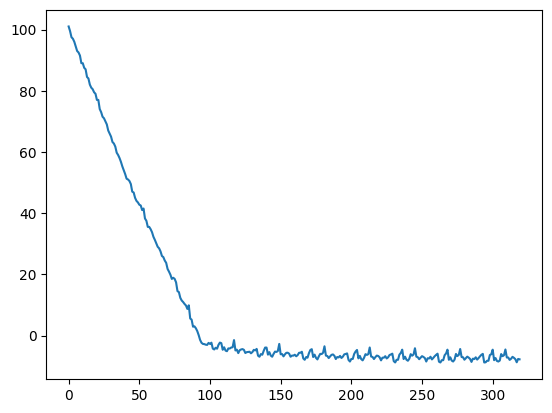

In [26]:
from matplotlib import pyplot as plt

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/test_localization_code",
    mt.name.split("/")[-1],
    f"{TASK_CLS.task_name}",
    "legacy",
    "epoch_10.npz",
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])

118


(True, True)

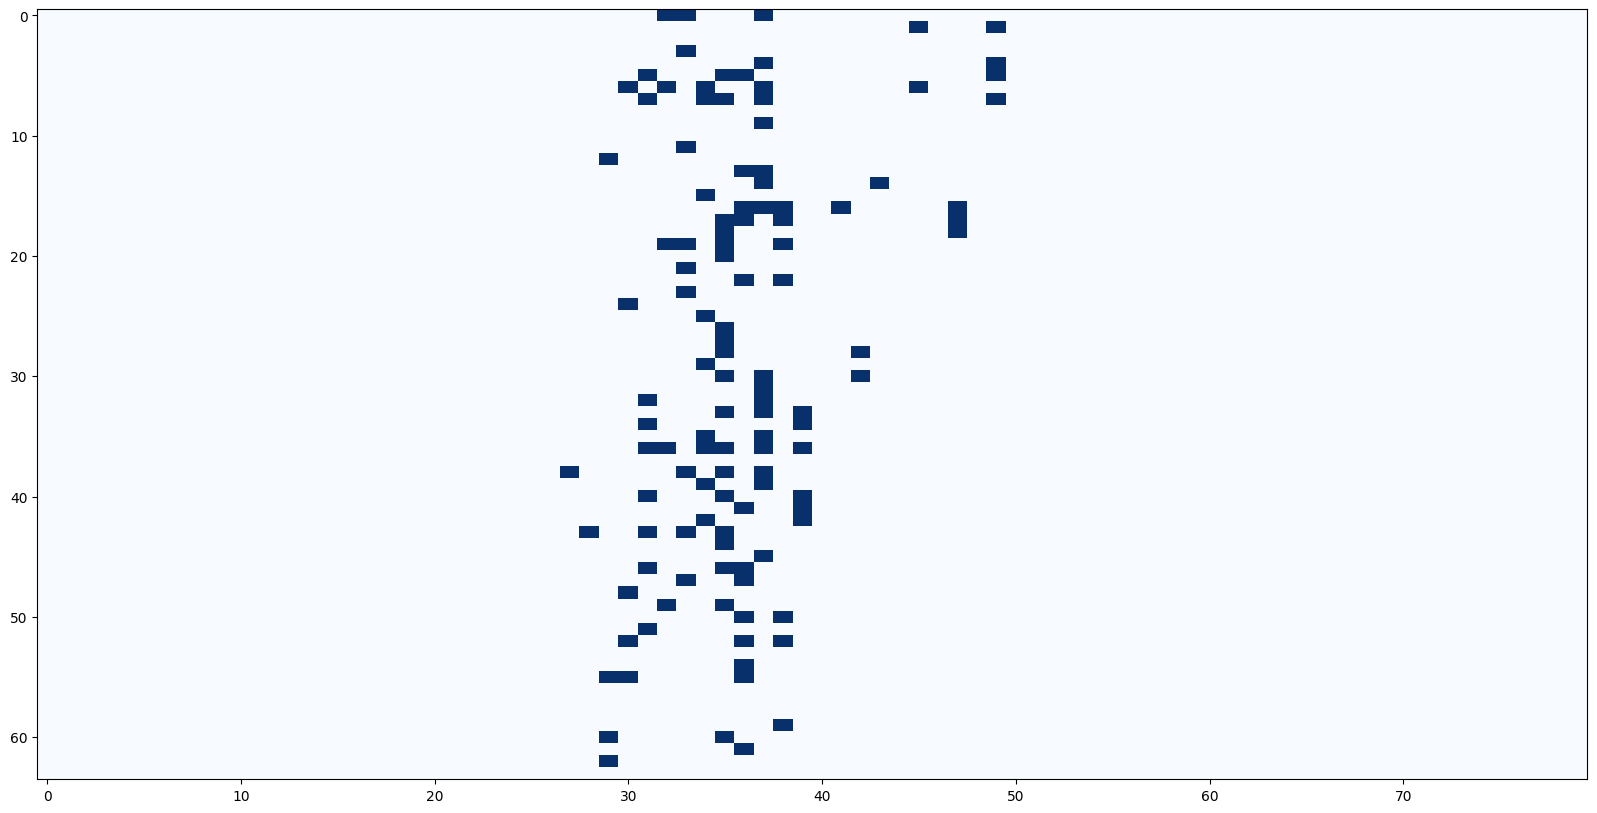

In [27]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[50:, :] = 0.0
# optimal_head_mask[75:, :] = 0.0
# optimal_head_mask[37:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

optimized_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).to(dtype=torch.int).tolist()
optimized_heads = [
    (layer_idx, head_idx) for layer_idx, head_idx in optimized_heads
]
print(len(optimized_heads))

HEADS = optimized_heads

(35, 19) in HEADS, (35, 19) in optimized_heads

## Validation of the patching effect

In [ ]:
from src.selection.data import CounterFactualSamplePair, get_counterfactual_samples_interface
from src.functional import free_gpu_cache
validation_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    select_task.task_name,
    "objects",
)
os.makedirs(validation_samples_save_path, exist_ok=True)

free_gpu_cache()
validation_set = []
validation_limit = 255
start_number = 1

counterfactual_sampler = get_counterfactual_samples_interface[select_task.task_name]

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = counterfactual_sampler(
        mt=mt,
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        distinct_options=True,
        # # n_distractors=N_DISTRACTORS,
        # patch_n_distractors=N_DISTRACTORS,
        # clean_n_distractors=N_DISTRACTORS
        n_options = random.choice([4, 5, 6, 7])
    )
    validation_set.append((clean, patch))
    cf_pair = CounterFactualSamplePair(
        patch_sample=patch,
        clean_sample=clean,
    )
    cf_pair.detensorize()
    with open(
        os.path.join(validation_samples_save_path, f"{len(validation_set) + start_number - 1:05d}.json"),
        "w",
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=2)

len(validation_set)

sample 1 / 257
2025-09-14 20:07:57 src.selection.data DEBUG    Options: Microwave, Oven, Jasmine, Tie, Apartment, School.
What is the first building from the list above?
Answer: >>  Apartment
2025-09-14 20:07:58 src.selection.data DEBUG    Options: Dress, Mall, Library, Daisy, Kettle, Slow cooker.
What is the first kitchen appliance from the list above?
Answer: >>  K
2025-09-14 20:07:58 src.selection.data DEBUG    Options: Dress, Mall, Library, Daisy, Kettle, Slow cooker.
What is the first building from the list above?
Answer: >>  Mall
2025-09-14 20:07:58 src.selection.data ERROR    Prediction mismatch: (1, PredictedToken(token=' Library', prob=0.376953125, logit=20.625, token_id=11896, metadata=None))[" Library"] != 32498[" Mall"]
2025-09-14 20:07:58 src.selection.data DEBUG    Options: Temple, Air fryer, Tie, Soap, Slow cooker, Skyscraper.
What is the first building from the list above?
Answer: >>  Temple
2025-09-14 20:07:58 src.selection.data DEBUG    Options: Oven, Warehouse, Hat, 

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f6e8f72d990>>
Traceback (most recent call last):
  File "/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


sample 3 / 257
2025-09-14 20:08:08 src.selection.data DEBUG    Options: Car, Motorcycle, Dolphin, Tablet, Iris, Lotion, Tulip.
What is the first vehicle from the list above?
Answer: >>  Car
2025-09-14 20:08:09 src.selection.data DEBUG    Options: Toothpaste, Scooter, Keyboard, Bus, Tiger, Rose, Orchid.
What is the first flower from the list above?
Answer: >>  Rose
2025-09-14 20:08:09 src.selection.data DEBUG    Options: Toothpaste, Scooter, Keyboard, Bus, Tiger, Rose, Orchid.
What is the first vehicle from the list above?
Answer: >>  Sco
sample 4 / 257
2025-09-14 20:08:13 src.selection.data DEBUG    Options: Daffodil, Refrigerator, Microwave, Scooter, Coffee table, Car.
What is the first vehicle from the list above?
Answer: >>  Sco
2025-09-14 20:08:13 src.selection.data DEBUG    Options: Chair, Submarine, Mixer, Boat, Chrysanthemum, Food processor.
What is the first kitchen appliance from the list above?
Answer: >>  Mixer
2025-09-14 20:08:13 src.selection.data DEBUG    Options: Chair, 

In [ ]:
from src.selection.data import CounterFactualSamplePair
from src.functional import free_gpu_cache
from src.selection.data import get_counterfactual_samples_interface
import random

validation_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    select_task.task_name,
    "objects",
)

os.makedirs(validation_samples_save_path, exist_ok=True)


free_gpu_cache()
validation_set = []
validation_limit = 1024

counterfactual_sampler = get_counterfactual_samples_interface[select_task.task_name]

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = counterfactual_sampler(
        mt=mt,
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=3,
        option_style=OPTION_STYLE,
        n_distractors=random.choice(range(2, 6)),
    )
    validation_set.append((clean, patch))
    cf_pair = CounterFactualSamplePair(
        patch_sample=patch,
        clean_sample=clean,
    )
    cf_pair.detensorize()
    with open(
        os.path.join(validation_samples_save_path, f"{len(validation_set):05d}.json"),
        "w",
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=2)

len(validation_set)

sample 1 / 1024
2025-09-15 09:32:52 src.selection.data DEBUG    Options: Toothbrush, Basketball, Smartwatch, Hairdryer, Speaker.
What is the last electronics in this list above?
Answer: >>  Speaker
2025-09-15 09:32:53 src.selection.data DEBUG    Options: Monitor, Phone, Sink, Comb, Racket.
What is the last bathroom item in this list above?
Answer: >>  Comb
2025-09-15 09:32:53 src.selection.data ERROR    Prediction mismatch: (1, PredictedToken(token=' Sink', prob=0.765625, logit=20.25, token_id=57551, metadata=None))[" Sink"] != 23262[" Comb"]
2025-09-15 09:32:53 src.selection.data DEBUG    Options: Sink, Calculator, Bathtub, Microphone, Monitor.
What is the last electronics in this list above?
Answer: >>  Monitor
2025-09-15 09:32:53 src.selection.data DEBUG    Options: Laptop, Toilet paper, Phone, Paper, Toilet.
What is the last bathroom item in this list above?
Answer: >>  Toilet
2025-09-15 09:32:53 src.selection.data DEBUG    Options: Laptop, Toilet paper, Phone, Paper, Toilet.
What 

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f71c08e5b10>>
Traceback (most recent call last):
  File "/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


sample 3 / 1024
2025-09-15 09:33:01 src.selection.data DEBUG    Options: Horse, Anklet, Golf ball, Necklace, Cow.
What is the last animal in this list above?
Answer: >>  Cow
2025-09-15 09:33:01 src.selection.data DEBUG    Options: Monkey, Sheep, Charm, Pendant, Tennis ball.
What is the last jewelry in this list above?
Answer: >>  Pendant
2025-09-15 09:33:01 src.selection.data DEBUG    Options: Monkey, Sheep, Charm, Pendant, Tennis ball.
What is the last animal in this list above?
Answer: >>  Sheep
sample 4 / 1024
2025-09-15 09:33:04 src.selection.data DEBUG    Options: Lavender, Tulip, Gloves, Paperclip, Highlighter.
What is the last office supply in this list above?
Answer: >>  Highlight
2025-09-15 09:33:05 src.selection.data DEBUG    Options: Folder, Tie, Calculator, Orchid, Iris.
What is the last flower in this list above?
Answer: >>  Iris
2025-09-15 09:33:05 src.selection.data DEBUG    Options: Folder, Tie, Calculator, Orchid, Iris.
What is the last office supply in this list above

In [98]:
select_task.task_name

'select_one'

In [27]:
from src.selection.data import CounterFactualSamplePair
import random

validation_set = []
validation_limit = 1024

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    select_task.task_name,
    "objects",
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    validation_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(validation_set)

2025-09-15 09:35:15 __main__ INFO     Found 511 sample files


511

In [28]:
clean, patch = validation_set[3]
print(patch.prompt(), ">>", mt.tokenizer.decode(patch.ans_token_id))
print(clean.prompt(), ">>", mt.tokenizer.decode(clean.ans_token_id))
clean.metadata["track_type_obj_token_id"], mt.tokenizer.decode(clean.metadata["track_type_obj_token_id"])

Options: Monitor, Keyboard, Notebook, Dog, Stapler.
What is the last office supply in this list above?
Answer: >>  Stap
Options: Pencil, Eraser, Eagle, Headphones, Router.
What is the last electronics in this list above?
Answer: >>  Router


(9939, ' Er')

In [29]:
from typing import Any, Optional
from src.utils.typing import TokenizerOutput
from src.functional import get_module_nnsight, PatchSpec, patch_with_baukit
import baukit
import types
from src.hooking.llama_attention import LlamaAttentionPatcher
from src.attention import visualize_attn_matrix
from src.selection.data import SelectionSample, CountingSample
from src.selection.data import get_options_for_answer


@torch.inference_mode()
def cache_q_projections(
    mt: ModelandTokenizer,
    input: TokenizerOutput,
    heads: list[tuple[int, int]],  # (layer_idx, head_idx)
    token_indices: list[list[int]],
    return_output: bool = False,
    projection_signature: str = ".q_proj",
):
    batch_size = input.input_ids.shape[0]
    assert len(token_indices) == batch_size, f"{len(token_indices)=} != {batch_size=}"
    layer_to_head = {}
    for layer_idx, head_idx in heads:
        if layer_idx not in layer_to_head:
            layer_to_head[layer_idx] = []
        layer_to_head[layer_idx].append(head_idx)

    seq_len = input.input_ids.shape[1]
    n_heads = mt.config.num_attention_heads
    # head_dim = mt.n_embd // n_heads
    head_dim = get_module_nnsight(
        mt._model, mt.attn_module_name_format.format(0)
    ).head_dim
    group_size = n_heads // mt.config.num_key_value_heads
    q_module_projections_per_layer = {}
    with mt.trace(input) as tracer:  # noqa
        for layer_idx, head_indices in layer_to_head.items():
            q_proj_name = (
                mt.attn_module_name_format.format(layer_idx) + projection_signature
            )
            q_proj_module = get_module_nnsight(mt, q_proj_name)
            q_module_projections_per_layer[q_proj_name] = q_proj_module.output.save()

        if return_output:
            output = mt.output.save()

    q_projections = [{} for _ in range(batch_size)]
    for layer_idx, head_indices in layer_to_head.items():
        q_proj_name = (
            mt.attn_module_name_format.format(layer_idx) + projection_signature
        )
        # print(q_proj_name)
        q_proj_out = (
            q_module_projections_per_layer[q_proj_name]
            .view(batch_size, seq_len, -1, head_dim)
            .transpose(1, 2)
        )
        if projection_signature in [".k_proj", ".v_proj"] and group_size != 1:
            q_proj_out = repeat_kv(q_proj_out, n_rep=group_size)
        # print(q_proj_out.shape, q_proj_out.norm())
        for prompt_idx in range(batch_size):
            for head_idx in head_indices:
                for token_idx in token_indices[prompt_idx]:
                    q_projections[prompt_idx][(layer_idx, head_idx, token_idx)] = (
                        q_proj_out[prompt_idx, head_idx, token_idx]
                    )

    if return_output:
        return q_projections, output
    return q_projections


def locate_with_delim(prompt, option):
    st = prompt.index(option)
    return prompt[st : st + len(option) + 1]


@torch.no_grad()
def validate_q_proj_ie_on_sample_pair(
    mt: ModelandTokenizer,
    clean_sample: SelectionSample | CountingSample,
    patch_sample: SelectionSample | CountingSample,
    heads: list[tuple[int, int]],
    query_indices: dict[int, int] = {-1: -1},  # patch_idx -> clean_idx
    verify_head_behavior_on: Optional[int] = None,
    ablate_possible_ans_info_from_options: bool = False,
    amplification_scale: float = 1.0,
    must_track_tokens: list[int] = [],
    patch_args: dict[str, Any] = {},
):
    clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
    patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)
    if patch_args.get("batch_size", 1) > 1:
        patch_samples = []
        task = patch_args["task"]
        logger.debug(f"Sampling {patch_args.get('batch_size', 1)} patch samples...")
        while len(patch_samples) < patch_args.get("batch_size", 1):
            obj_idx = len(patch_samples) % len(patch_sample.options)
            if patch_args["distinct_options"] is True:
                sample = task.get_random_sample(
                    mt=mt,
                    category=patch_sample.category,
                    prompt_template_idx=patch_args["prompt_template_idx"],
                    option_style=patch_args["option_style"],
                    filter_by_lm_prediction=True,
                    # exclude_objs=[clean_sample.obj, patch_sample.obj],
                    n_distractors=patch_args["n_distractors"],
                    obj_idx=obj_idx,
                )
            else:
                sample = copy.deepcopy(patch_sample)
                sample.options[obj_idx], sample.options[sample.obj_idx] = (
                    sample.options[sample.obj_idx],
                    sample.options[obj_idx],
                )
                sample.obj_idx = obj_idx
                # random.shuffle(sample.options)
            patch_samples.append(sample)
        patch_tokenized_batch = prepare_input(
            prompts=[sample.prompt() for sample in patch_samples], tokenizer=mt
        )
        logger.debug(f"{patch_tokenized_batch.input_ids.shape}")

    if verify_head_behavior_on is not None:
        logger.info("Verifying head behavior...")

        logger.info(f"Clean Sample >> Ans: {mt.tokenizer.decode(clean_sample.ans_token_id)}")
        clean_attn_pattern = verify_head_patterns(  # noqa
            prompt=clean_sample.prompt(),
            tokenized_prompt=clean_tokenized,
            options=(
                [
                    locate_with_delim(clean_sample.prompt(), opt)
                    for opt in clean_sample.options
                ]
                if ablate_possible_ans_info_from_options
                else clean_sample.options
            ),
            mt=mt,
            heads=heads,
            generate_full_answer=False,
            query_index=verify_head_behavior_on,
            ablate_possible_ans_info_from_options=ablate_possible_ans_info_from_options,
        )

        logger.info(f"Patch Sample >> Ans: {mt.tokenizer.decode(patch_sample.ans_token_id)}")
        patch_attn_pattern = verify_head_patterns(  # noqa
            prompt=patch_sample.prompt(),
            tokenized_prompt=patch_tokenized,
            options=(
                [
                    locate_with_delim(patch_sample.prompt(), opt)
                    for opt in patch_sample.options
                ]
                if ablate_possible_ans_info_from_options
                else patch_sample.options
            ),
            mt=mt,
            heads=heads,
            generate_full_answer=False,
            query_index=verify_head_behavior_on,
            ablate_possible_ans_info_from_options=ablate_possible_ans_info_from_options,
        )

    logger.info(f"Caching the query states for the {len(heads)} heads")

    cached_q_states, patch_output = cache_q_projections(
        mt=mt,
        input=patch_tokenized,
        heads=heads,
        token_indices=[list(query_indices.keys())],
        return_output=True,
    )
    if patch_args.get("batch_size", 1) > 1:
        cached_q_states = cache_q_projections(
            mt=mt,
            input=patch_tokenized_batch,
            heads=heads,
            token_indices=[list(query_indices.keys())]
            * patch_args.get("batch_size", 1),
            return_output=False,
        )
        mean_q_states = {}
        for prompt_idx in range(patch_args.get("batch_size", 1)):
            for key, value in cached_q_states[prompt_idx].items():
                if key not in mean_q_states:
                    mean_q_states[key] = []
                mean_q_states[key].append(value)
        for key, value in mean_q_states.items():
            mean_q_states[key] = torch.mean(torch.stack(value), dim=0)
        cached_q_states = [mean_q_states]

    q_proj_patches = []
    for (layer_idx, head_idx, patch_query_idx), q_proj in cached_q_states[0].items():
        q_proj_patches.append(
            PatchSpec(
                location=(
                    mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                    head_idx,
                    query_indices[patch_query_idx],
                ),
                patch=q_proj,
            )
        )

    patch_logits = patch_output.logits[:, -1, :].squeeze()
    patch_predictions = interpret_logits(
        tokenizer=mt,
        logits=patch_logits,
    )
    logger.info(f"patch_prediction={[str(pred) for pred in patch_predictions]}")

    # interested_tokens = [
    #     patch_sample.ans_token_id,
    #     clean_sample.ans_token_id,
    #     clean_sample.metadata["track_type_obj_token_id"],
    # ]
    interested_tokens = get_options_for_answer(sample=clean_sample)
    interested_tokens = [
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in interested_tokens
    ]
    # interested_tokens += [patch_sample.ans_token_id]
    # interested_tokens = list(set(interested_tokens))  # remove duplicates #! don't need to, made sure during sampling

    logger.info("clean run")
    clean_output = patch_with_baukit(
        mt=mt,
        inputs=clean_tokenized,
        patches=[],
    )
    clean_logits = clean_output.logits[:, -1, :].squeeze()
    clean_predictions, clean_track = interpret_logits(
        tokenizer=mt,
        logits=clean_logits,
        interested_tokens=interested_tokens + must_track_tokens,
    )
    logger.info(f"clean_prediction={[str(pred) for pred in clean_predictions]}")
    logger.info(f"clean_track={clean_track}")

    logger.info("patching the q_proj states")

    if verify_head_behavior_on is not None and amplification_scale == 1.0:
        int_attn_pattern = verify_head_patterns(
            prompt=clean_sample.prompt(),
            tokenized_prompt=clean_tokenized,
            options=(
                [
                    locate_with_delim(clean_sample.prompt(), opt)
                    for opt in clean_sample.options
                ]
                if ablate_possible_ans_info_from_options
                else clean_sample.options   
            ),
            mt=mt,
            heads=heads,
            query_patches=q_proj_patches,
            generate_full_answer=False,
            query_index=verify_head_behavior_on,
            ablate_possible_ans_info_from_options=ablate_possible_ans_info_from_options,
        )
        int_logits = int_attn_pattern["logits"].squeeze()

    else:
        default_attn_implementation = mt.config._attn_implementation
        if amplification_scale != 1.0:
            mt.reset_forward()
            mt.set_attn_implementation("sdpa")

            layers_to_heads = {}
            for layer_idx, head_idx in heads:
                if layer_idx not in layers_to_heads:
                    layers_to_heads[layer_idx] = []
                layers_to_heads[layer_idx].append(head_idx)

            layers_to_q_patches = {}
            for (
                layer_idx,
                head_idx,
                patch_query_idx,
            ), patch in cached_q_states[0].items():
                if layer_idx not in layers_to_q_patches:
                    layers_to_q_patches[layer_idx] = []
                layers_to_q_patches[layer_idx].append(
                    (head_idx, query_indices[patch_query_idx], patch)
                )

            attention_patterns = {}
            head_contributions = {}
            for layer_idx, head_indices in layers_to_heads.items():
                attn_block_name = mt.attn_module_name_format.format(layer_idx)
                attn_block = baukit.get_module(mt._model, attn_block_name)

                attention_patterns[layer_idx] = {}
                head_contributions[layer_idx] = {}

                attn_block.forward = types.MethodType(
                    LlamaAttentionPatcher(
                        block_name=attn_block_name,
                        save_attn_for=head_indices,
                        store_attn_matrices=attention_patterns[layer_idx],
                        store_head_contributions=head_contributions[layer_idx],
                        query_patches=layers_to_q_patches[layer_idx],
                        amplify_contributions=[
                            (head_idx, q_idx, amplification_scale)
                            for head_idx in head_indices
                            for q_idx in query_indices.values()
                        ],
                        # value_weighted=True,
                    ),
                    attn_block,
                )
            patches = []  # already handled by hooking the default forward pass

        else:
            patches = q_proj_patches

        if ablate_possible_ans_info_from_options:
            patches.extend(
                get_patches_to_verify_independent_enrichment(
                    prompt=clean_sample.prompt(),
                    options=clean_sample.options,
                    pivot=clean_sample.subj,
                    mt=mt,
                    tokenized_prompt=clean_tokenized,
                )
            )

        int_out = patch_with_baukit(
            mt=mt,
            inputs=clean_tokenized,
            patches=patches,
        )
        int_logits = int_out.logits[:, -1, :].squeeze()

        if amplification_scale != 1.0:
            mt.reset_forward()
            mt.set_attn_implementation(default_attn_implementation)

            if verify_head_behavior_on is not None:
                attn_matrix = []
                for layer_idx in attention_patterns:
                    for head_idx in attention_patterns[layer_idx]:
                        attn_matrix.append(
                            attention_patterns[layer_idx][head_idx].cpu()
                        )

                attn_matrix = torch.stack(attn_matrix).squeeze()
                if attn_matrix.dim() == 3:
                    attn_matrix = attn_matrix.mean(dim=0)

                visualize_attn_matrix(
                    attn_matrix=attn_matrix,
                    tokens=[
                        mt.tokenizer.decode(t) for t in clean_tokenized["input_ids"][0]
                    ],
                )

    int_predictions, int_track = interpret_logits(
        tokenizer=mt,
        logits=int_logits,
        interested_tokens=interested_tokens + must_track_tokens,
    )
    logger.info(f"int_prediction={[str(pred) for pred in int_predictions]}")
    logger.info(f"int_track={int_track}")

    return {
        "clean_sample": clean_sample,
        "patch_sample": patch_sample,
        "clean_predictions": clean_predictions,
        "patch_predictions": patch_predictions,
        "int_predictions": int_predictions,
        "clean_track": clean_track,
        "int_track": int_track,
    }

In [31]:
# no_attn = set(optimized_heads) - set(heads_max_ie)
# no_attn

In [32]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair

clean, patch = copy.deepcopy(validation_set[15])
# clean.default_option_style="numbered"
# patch.default_option_style="numbered"
# clean, patch = train_set[18]

# clean, patch = copy.deepcopy(clean_sample), copy.deepcopy(patch_sample)

# failed_case = failed_cases[27]
# clean = failed_case["clean_sample"]
# patch = failed_case["patch_sample"]

print(clean.prompt(), ">>", mt.tokenizer.decode(clean.ans_token_id))
print(patch.prompt(), ">>", mt.tokenizer.decode(patch.ans_token_id))

mt.set_attn_implementation("eager")
mt.reset_forward()

validation_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    heads=optimized_heads,
    # heads=sorted(heads_max_ie),
    # heads=sorted(list(no_attn)),
    # heads=sorted(qwen_32_heads, key=lambda x: (x[0], x[1])),
    # heads=sorted(heads_attn_behavior, key=lambda x: (x[0], x[1])),
    # heads=[(35, 19)],
    # query_indices={
    #     patch.metadata["ques_pos"]: clean.metadata["ques_pos"],
    #     -2: -2,
    #     -1: -1,
    # },
    query_indices={tok_idx: tok_idx for tok_idx in range(-10, 0)},
    # verify_head_behavior_on=clean.metadata["ques_pos"]
    verify_head_behavior_on=-1,
    # ablate_possible_ans_info_from_options=True,
    # amplification_scale=2.0
    # patch_args={
    #     "batch_size": N_DISTRACTORS + 1,
    #     "task": select_task,
    #     "prompt_template_idx": prompt_template_idx,
    #     "option_style": patch.default_option_style,
    #     "distinct_options": False,
    #     "n_distractors": N_DISTRACTORS,
    # },
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": validation_result["clean_track"][clean_obj][0],
    "clean_logit": validation_result["clean_track"][clean_obj][1].logit,
    "target_rank": validation_result["clean_track"][target_obj][0],
    "target_logit": validation_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": validation_result["int_track"][clean_obj][0],
    "clean_logit": validation_result["int_track"][clean_obj][1].logit,
    "target_rank": validation_result["int_track"][target_obj][0],
    "target_logit": validation_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

Options: Cedar, Wardrobe, Cufflink, Hickory, Anklet.
What is the last jewelry in this list above?
Answer: >>  Ank
Options: Elm, Palm, Pendant, Locket, Sofa.
What is the last tree in this list above?
Answer: >>  Palm
2025-09-15 09:35:40 src.selection.optimization INFO     Verifying head behavior...
2025-09-15 09:35:40 src.selection.optimization INFO     Clean Sample >> Ans:  Ank


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-15 09:35:46 src.selection.functional DEBUG    Generated full answer: " Anklet.
Explanation: The last jewelry in the list above is an Anklet. An anklet is a type of jewelry that is worn around the"
2025-09-15 09:35:46 src.selection.functional DEBUG    Predictions: ['" Ank"[57915] (p=0.762, logit=19.250)', '" The"[578] (p=0.055, logit=16.625)', '" C"[356] (p=0.043, logit=16.375)', '" ank"[71572] (p=0.017, logit=15.438)', '" An"[1556] (p=0.017, logit=15.438)']
2025-09-15 09:35:46 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-15 09:35:46 src.selection.optimization INFO     Patch Sample >> Ans:  Palm


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-15 09:35:52 src.selection.functional DEBUG    Generated full answer: " Palm.
The last tree in the list is the Palm tree. The other options are not trees: Elm is a type of tree, but it's"
2025-09-15 09:35:52 src.selection.functional DEBUG    Predictions: ['" Palm"[33578] (p=0.730, logit=19.375)', '" Elm"[65329] (p=0.053, logit=16.750)', '" The"[578] (p=0.047, logit=16.625)', '" Pendant"[81501] (p=0.022, logit=15.875)', '" L"[445] (p=0.021, logit=15.812)']
2025-09-15 09:35:52 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-15 09:35:52 src.selection.optimization INFO     Caching the query states for the 79 heads
2025-09-15 09:35:53 src.selection.optimization INFO     patch_prediction=['" Palm"[33578] (p=0.730, logit=19.375)', '" Elm"[65329] (p=0.053, logit=16.750)', '" The"[578] (p=0.047, logit=16.625)', '" Pendant"[81501] (p=0.022, logit=15.875)', '" L"[445] (p=0.021, logit=15.812)']
2025-09-15 09:35:53 src.selection.optimization INFO     clean run
2025-09-15 09:35:53 src.selection.optimization INFO     clean_prediction=['" Ank"[57915] (p=0.762, logit=19.250)', '" The"[578] (p=0.055, logit=16.625)', '" C"[356] (p=0.043, logit=16.375)', '" ank"[71572] (p=0.017, logit=15.438)', '" An"[1556] (p=0.017, logit=15.438)']
2025-09-15 09:35:53 src.selection.optimization INFO     clean_track=OrderedDict([(57915, (1, PredictedToken(token=' Ank', prob=0.76171875, logit=19.25, token_id=57915, metadata=None))), (356, (3, PredictedToken(token=' C', prob=0.04296875, logit=16.375, token_id=356, metadata=None))), (

2025-09-15 09:35:53 src.selection.optimization INFO     int_prediction=['" Hick"[79028] (p=0.586, logit=18.250)', '" The"[578] (p=0.070, logit=16.125)', '" Ank"[57915] (p=0.058, logit=15.938)', '" C"[356] (p=0.045, logit=15.688)', '" None"[2290] (p=0.033, logit=15.375)']
2025-09-15 09:35:53 src.selection.optimization INFO     int_track=OrderedDict([(79028, (1, PredictedToken(token=' Hick', prob=0.5859375, logit=18.25, token_id=79028, metadata=None))), (57915, (3, PredictedToken(token=' Ank', prob=0.05810546875, logit=15.9375, token_id=57915, metadata=None))), (356, (4, PredictedToken(token=' C', prob=0.045166015625, logit=15.6875, token_id=356, metadata=None))), (27738, (6, PredictedToken(token=' Ward', prob=0.0291748046875, logit=15.25, token_id=27738, metadata=None))), (57748, (7, PredictedToken(token=' Cedar', prob=0.0274658203125, logit=15.1875, token_id=57748, metadata=None)))])
2025-09-15 09:35:53 __main__ DEBUG    clean obj:  Ank
2025-09-15 09:35:53 __main__ DEBUG    target obj:

In [33]:
print(clean_sample.options)
print(clean_sample.prompt())

['Boat', 'Watermelon', 'Blueberry', 'Bus', 'Helmet']
Options: Boat, Watermelon, Blueberry, Bus, Helmet.
What is the last vehicle in this list above?
Answer:


In [34]:
# from src.selection.functional import cache_q_projections, verify_head_patterns
# from typing import Literal
# from src.functional import PatchSpec, interpret_logits
# from src.hooking.llama_attention import LlamaAttentionPatcher
# import baukit
# import types


# def set_attn_implementation(mt, attn_implementation: Literal["sdpa", "eager"]):
#     mt.config._attn_implementation = attn_implementation
#     for layer_idx in range(mt.config.num_hidden_layers):
#         attn_block_name = mt.attn_module_name_format.format(layer_idx)
#         attn_block = baukit.get_module(mt._model, attn_block_name)
#         attn_block.config._attn_implementation = attn_implementation


# ##########################################################
# query_indices = [-3, -2, -1]
# heads = optimized_heads
# ##########################################################

# mt.reset_forward()
# set_attn_implementation(mt, "eager")

# clean_sample = failed_case["clean_sample"]
# patch_sample = failed_case["patch_sample"]

# clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
# patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)

# verify_head_patterns(
#     prompt=patch_sample.prompt(),
#     tokenized_prompt=patch_tokenized,
#     pivot=patch_sample.subj,
#     options=patch_sample.options,
#     mt=mt,
#     heads=heads,
#     query_index=-1,
# )

# verify_head_patterns(
#     prompt=clean_sample.prompt(),
#     tokenized_prompt=clean_tokenized,
#     pivot=clean_sample.subj,
#     options=clean_sample.options,
#     mt=mt,
#     heads=heads,
#     query_index=-1,
# )

# query_locations = [
#     (layer_idx, head_idx, query_idx)
#     for layer_idx, head_idx in heads
#     for query_idx in query_indices
# ]

# cached_q_states, patch_output = cache_q_projections(
#     mt=mt,
#     input=patch_tokenized,
#     query_locations=query_locations,
#     return_output=True,
# )
# q_proj_patches = []
# for (layer_idx, head_idx, query_idx), q_proj in cached_q_states.items():
#     q_proj_patches.append(
#         PatchSpec(
#             location=(
#                 mt.attn_module_name_format.format(layer_idx) + ".q_proj",
#                 head_idx,
#                 query_idx,
#             ),
#             patch=q_proj,
#         )
#     )

# patch_logits = patch_output.logits[:, -1, :].squeeze()
# patch_predictions = interpret_logits(
#     tokenizer=mt,
#     logits=patch_logits,
# )
# logger.info(f"patch_prediction={[str(pred) for pred in patch_predictions]}")


# mt.reset_forward()
# set_attn_implementation(mt, "sdpa")

# layers_to_heads = {}
# for layer_idx, head_idx in heads:
#     if layer_idx not in layers_to_heads:
#         layers_to_heads[layer_idx] = []
#     layers_to_heads[layer_idx].append(head_idx)

# layers_to_q_patches = {}
# for (layer_idx, head_idx, query_idx), patch in cached_q_states.items():
#     if layer_idx not in layers_to_q_patches:
#         layers_to_q_patches[layer_idx] = []
#     layers_to_q_patches[layer_idx].append((head_idx, query_idx, patch))

# attention_patterns = {}
# head_contributions = {}
# for layer_idx, head_indices in layers_to_heads.items():
#     attn_block_name = mt.attn_module_name_format.format(layer_idx)
#     attn_block = baukit.get_module(mt._model, attn_block_name)

#     attention_patterns[layer_idx] = {}
#     head_contributions[layer_idx] = {}

#     attn_block.forward = types.MethodType(
#         LlamaAttentionPatcher(
#             block_name=attn_block_name,
#             save_attn_for=head_indices,
#             store_attn_matrices=attention_patterns[layer_idx],
#             store_head_contributions=head_contributions[layer_idx],
#             query_patches=layers_to_q_patches[layer_idx],
#             amplify_contributions=[
#                 (head_idx, q_idx, 2.0)
#                 for head_idx in head_indices
#                 for q_idx in query_indices
#             ],
#             # value_weighted=True,
#         ),
#         attn_block,
#     )


# output = mt._model(**clean_tokenized)
# int_logits = output.logits[:, -1, :].squeeze()
# int_pred = interpret_logits(
#     tokenizer=mt,
#     logits=int_logits,
# )

# logger.info(f"int_prediction={[str(pred) for pred in int_pred]}")

# mt.reset_forward()
# set_attn_implementation(mt, "eager")

In [35]:
# from src.selection.functional import visualize_attn_matrix

# attn_matrix = []
# for layer_idx in attention_patterns:
#     for head_idx in attention_patterns[layer_idx]:
#         attn_matrix.append(attention_patterns[layer_idx][head_idx].cpu())
# attn_matrix = torch.stack(attn_matrix).squeeze().mean(dim=0)

# visualize_attn_matrix(
#     attn_matrix = attn_matrix,
#     tokens = [mt.tokenizer.decode(t) for t in clean_tokenized["input_ids"][0]]
# )



In [36]:
# heads_attn_behavior
# for layer_idx, head_idx, score in scores_per_head[:79]:
#     print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")

# heads_max_ie = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in scores_per_head[:79]
# ]

heads_max_ie = []
for layer_idx, head_idx, score in scores_per_head:
    if layer_idx < 55 and layer_idx > 25:
        heads_max_ie.append((layer_idx, head_idx))
    if len(heads_max_ie) >= 80:
        break

heads_max_ie = sorted(heads_max_ie, key=lambda x: (x[0], x[1]))
len(heads_max_ie)

NameError: name 'scores_per_head' is not defined

In [37]:
from tqdm.auto import tqdm
from src.selection.optimization import validate_q_proj_ie_on_sample_pair

validation_results = []
for clean_sample, patch_sample in tqdm(validation_set):
    result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=optimized_heads,
        # heads = sorted(heads_attn_behavior),
        # heads = sorted(heads_max_ie),
        # heads=backup_heads,
        # heads=optimized_heads + backup_heads,
        # heads = overlapping_heads,
        query_indices={-2: -2, -1: -1},
        add_ques_pos_to_query_indices=True,
        # query_indices={tok_idx: tok_idx for tok_idx in range(-10, 0)},
        verify_head_behavior_on=None,
        # amplification_scale=1.5
        patch_args={
            "batch_size": len(patch_sample.options),
            "distinct_options": False,
        },
    )
    validation_results.append(result)
    print("=" * 80)

  0%|          | 0/511 [00:00<?, ?it/s]

2025-09-15 09:36:45 src.selection.optimization DEBUG    Sampling 4 patch samples...


2025-09-15 09:36:45 src.selection.optimization DEBUG    torch.Size([4, 25])
2025-09-15 09:36:45 src.selection.optimization INFO     Caching the query states for the 79 heads
2025-09-15 09:36:46 src.selection.optimization INFO     patch_prediction=['" S"[328] (p=0.828, logit=20.125)', '" The"[578] (p=0.041, logit=17.125)', '" Boxing"[72683] (p=0.025, logit=16.625)', '" Basketball"[47589] (p=0.015, logit=16.125)', '" SOCK"[35651] (p=0.013, logit=16.000)']
2025-09-15 09:36:46 src.selection.optimization INFO     clean run
2025-09-15 09:36:46 src.selection.optimization INFO     clean_prediction=['" R"[432] (p=0.773, logit=19.875)', '" The"[578] (p=0.092, logit=17.750)', '" Tennis"[58251] (p=0.049, logit=17.125)', '" A"[362] (p=0.014, logit=15.875)', '" It"[1102] (p=0.009, logit=15.438)']
2025-09-15 09:36:46 src.selection.optimization INFO     clean_track=OrderedDict([(432, (1, PredictedToken(token=' R', prob=0.7734375, logit=19.875, token_id=432, metadata=None))), (58251, (3, PredictedToken

In [38]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [39]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 36.3620 ± 89.7851
target_rank_delta: -108.2133 ± 286.0976
clean_rank_after_intervention: 37.3620 ± 89.7851
target_rank_after_intervention: 1.8297 ± 5.9252


In [40]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: -5.5289 ± 2.7812
target_logit_delta: 6.6451 ± 2.6090
clean_logit_after_intervention: 14.5758 ± 2.6808
target_logit_after_intervention: 19.3168 ± 1.3884


In [41]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.7729941291585127

In [42]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)

Counterfactual patching accuracy: 0.7730 (395/511)


In [43]:
for failed_case in failed_cases[:20]:
    clean_sample = failed_case["clean_sample"]
    patch_sample = failed_case["patch_sample"]
    int_track = failed_case["int_track"]
    clean_track = failed_case["clean_track"]

    print("Clean Sample:")
    print(clean_sample.prompt(), ">>", mt.tokenizer.decode(clean_sample.ans_token_id))

    print("-" * 100)
    print(
        "Track: ",
        f"\"{mt.tokenizer.decode(clean_sample.metadata['track_type_obj_token_id'])}\"",
    )
    print(
        "Clean:",
        f"(Token: {mt.tokenizer.decode(clean_sample.ans_token_id)})",
    )
    print("-" * 100)

    clean_track = [pred for tok_id, (rank, pred) in clean_track.items()]
    print(f"Clean Track: {json.dumps([str(pred) for pred in clean_track], indent=4)}")

    int_track = [pred for tok_id, (rank, pred) in int_track.items()]
    print(
        f"Intervened Track: {json.dumps([str(pred) for pred in int_track], indent=4)}"
    )
    print("=" * 100)

Clean Sample:
Options: Blueberry, Hospital, Orange, Xylophone, Bear, Dog.
What is the last fruit in this list above?
Answer: >>  Orange
----------------------------------------------------------------------------------------------------
Track:  " Dog"
Clean: (Token:  Orange)
----------------------------------------------------------------------------------------------------
Clean Track: [
    "\" Orange\"[22725] (p=0.871, logit=21.625)",
    "\" Blue\"[8868] (p=0.008, logit=16.875)",
    "\" X\"[1630] (p=0.001, logit=15.062)",
    "\" Hospital\"[15429] (p=0.000, logit=14.125)",
    "\" Bear\"[24941] (p=0.000, logit=13.375)",
    "\" Dog\"[14588] (p=0.000, logit=12.438)"
]
Intervened Track: [
    "\" Bear\"[24941] (p=0.605, logit=20.750)",
    "\" Dog\"[14588] (p=0.254, logit=19.875)",
    "\" Orange\"[22725] (p=0.001, logit=13.750)",
    "\" Blue\"[8868] (p=0.000, logit=13.500)",
    "\" X\"[1630] (p=0.000, logit=12.688)",
    "\" Hospital\"[15429] (p=0.000, logit=12.500)"
]
Clean Samp

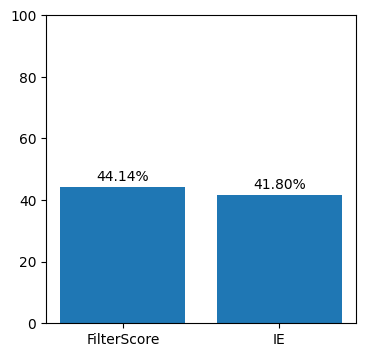

In [124]:
scores = {
    "FilterScore": 44.14,
    "IE": 41.80,
}


plt.figure(figsize=(4, 4))
bars = plt.bar(scores.keys(), scores.values())
plt.ylim(0, 100)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{height:.2f}%", ha='center', va='bottom')


## Heads found with different tasks

In [ ]:
task_names = [
    "select_one", 
    "select_order"
]
heads = {task_name: [] for task_name in task_names}
colors = {
    "select_one": "Blues",
    "select_order": "Reds",
}

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create combined mask for overlapping heads
combined_mask = np.zeros((mt.config.num_attention_heads, mt.n_layer)) 

for i, task_name in enumerate(task_names):
    print("Processing task:", task_name)

    optimized_path = os.path.join(
        env_utils.DEFAULT_RESULTS_DIR,
        "selection/optimized_heads",
        mt.name.split("/")[-1],
        f"{task_name}.npz",
    )
    optimization_results = np.load(optimized_path, allow_pickle=True)
    optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(
        torch.float32
    )
    print(f"Optimal head mask shape for {task_name}: {optimal_head_mask.shape}")
    
    # Get head positions
    task_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
    task_heads = [
        (layer_idx, head_idx) for layer_idx, head_idx in task_heads if layer_idx < 50
    ]
    heads[task_name] = task_heads
    
    # Prepare mask for visualization
    optimal_head_mask = optimal_head_mask.round()
    optimal_head_mask[50:] = 0
    
    # Create a masked array to handle transparency properly
    mask_array = optimal_head_mask.T.numpy()
    masked_data = np.ma.masked_where(mask_array == 0, mask_array)
    
    # Plot with proper alpha blending
    im = ax.imshow(
        masked_data,
        cmap=colors[task_name],
        aspect="auto",
        vmin=0,
        vmax=1.5,
        alpha=0.8 if i == 0 else 0.5,  # Different alphas for better visibility
        interpolation='nearest'
    )
    
    # Track overlaps (optional)
    combined_mask += mask_array * (i + 1)

# Add labels and formatting
ax.set_xlabel("Layer")
ax.set_ylabel("Head")
ax.set_title("Filter Heads Comparison: Select One (Blue) vs Select Order (Red)")

# Add grid for clarity
ax.set_xticks(np.arange(0, 50, 5))
ax.set_yticks(np.arange(0, optimal_head_mask.shape[1], 2))
ax.grid(True, alpha=0.3, linestyle='--')

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', alpha=0.5, label='Select One'),
    Patch(facecolor='blue', alpha=0.5, label='Select Order'),
    Patch(facecolor='purple', alpha=1, label='Overlap')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

# Optional: Print overlap statistics
overlapping_heads = []
for task1_head in heads["select_one"]:
    if task1_head in heads["select_order"]:
        overlapping_heads.append(task1_head)

print(f"Total heads for select_one: {len(heads['select_one'])}")
print(f"Total heads for select_order: {len(heads['select_order'])}")
print(f"Overlapping heads: {len(overlapping_heads)}")
if overlapping_heads:
    print(f"Overlapping positions: {overlapping_heads}")

In [ ]:
# find intersection of heads
overlapping_heads = set(heads[task_names[0]]) & set(heads[task_names[1]])
print(f"Intersection Heads: {len(overlapping_heads)}")